In [ ]:
import nltk
nltk.download('punkt')

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
import json

def distance_to_similarity(distances):
    return 1 / (1 + distances)

def kmeans_clustering_from_json(json_file, n_clusters, k_nearest=5):
    """
    Perform K-means clustering on a JSON file containing vectors.

    Parameters:
    - json_file: Path to the JSON file containing the data
    - n_clusters: Number of clusters for K-means
    - k_nearest: Number of nearest points to the cluster center to show (default is 5)

    Returns:
    - A DataFrame with cluster center, number of points in that cluster, 
      nearest k points to the cluster center from the same cluster, the 'radius',
      and the indices of points within each cluster.
    """
    
    # Load data from JSON file and convert to DataFrame
    with open(json_file) as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    # Ensure the 'vectors' column contains NumPy arrays
    df['vector'] = df['abstract'].apply(lambda x: model.encode(x))
    
    # Extract vectors from the DataFrame column
    vectors = np.stack(df['vector'].to_numpy())
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
    
    # Determine the nearest k points, the 'radius', and indices of points within each cluster
    nearest_points = []
    radii = []
    sum_of_similarities = []
    point_indices_within_cluster = []
    for i, center in enumerate(kmeans.cluster_centers_):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        cluster_vectors = vectors[cluster_indices]
        
        distances = np.array([distance.euclidean(center, vec) for vec in cluster_vectors])
        
        # Find the nearest k points within the cluster
        nearest_indices_in_cluster = distances.argsort()[:k_nearest]
        nearest_points.append(cluster_indices[nearest_indices_in_cluster].tolist())
        
        # Find the 'radius' as the distance to the most distant point within the cluster
        radii.append(max(distances))

        # Sum of similarities for points within the cluster
        cluster_similarities = distance_to_similarity(distances)
        sum_of_similarities.append(cluster_similarities.sum())

        # Store indices of points within the cluster
        point_indices_within_cluster.append(cluster_indices.tolist())
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'cluster_center': kmeans.cluster_centers_.tolist(),
        'number_of_points': [sum(kmeans.labels_ == i) for i in range(n_clusters)],
        'nearest_k_points': nearest_points,
        'radius': radii,
        'sum_of_similarities': sum_of_similarities,
        'point_indices_within_cluster': point_indices_within_cluster
    })

    output_df = output_df.sort_values(by='number_of_points', ascending=False).reset_index(drop=True)
    return output_df

# Example usage:
# output_df = kmeans_clustering_from_json('path_to_json_file.json', n_clusters=2, k_nearest=3)
# print(output_df)


In [ ]:
cluster_2023_cvpr = kmeans_clustering_from_json("2023_cvpr_abstracts.json", 50, k_nearest=5)
cluster_2023_icml = kmeans_clustering_from_json("2023_icml_abstracts.json", 50, k_nearest=5)
cluster_2022_neurips = kmeans_clustering_from_json("2022_neurips_abstracts.json", 50, k_nearest=5)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance
import re


def assign_points_and_find_within_radius(json_file, previous_centers, previous_radii):
    # Load data from JSON file and convert to DataFrame
    df = pd.read_json(json_file)
    df['vector'] = df['abstract'].apply(lambda x: model.encode(x))
    vectors = np.stack(df['vector'].to_numpy())

    # Convert the previous_centers from DataFrame column to 2D numpy array
    previous_centers_array = np.vstack(previous_centers)

    # Assign each 2022 data point to the nearest 2023 cluster center
    distances = pairwise_distances(vectors, previous_centers_array)
    labels = np.argmin(distances, axis=1)

    # Initialize variables to store results
    new_centers = []
    topic_shifts = []
    points_in_new_cluster = []
    points_within_2023_radius = []
    sum_of_similarities_within_circle = []
    point_indices_within_circle = []

    # Compute new centers and other metrics for each cluster
    for i in range(len(previous_centers)):
        cluster_indices = np.where(labels == i)[0]
        points_in_new_cluster.append(len(cluster_indices))

        if len(cluster_indices) == 0:
            new_center = np.full(vectors.shape[1], np.nan)
            topic_shift = np.nan
        else:
            new_center = np.mean(vectors[cluster_indices], axis=0)
            topic_shift = distance.euclidean(previous_centers[i], new_center)
        
        new_centers.append(new_center)
        topic_shifts.append(topic_shift)

        # Find points within the 2023 radius
        distances_to_prev_center = distances[cluster_indices, i]
        within_radius = cluster_indices[distances_to_prev_center <= previous_radii[i]]
        points_within_2023_radius.append(len(within_radius))

        # Compute sum of similarities for points within the circle
        similarities_within_circle = distance_to_similarity(distances_to_prev_center[distances_to_prev_center <= previous_radii[i]])
        sum_of_similarities_within_circle.append(similarities_within_circle.sum())
        point_indices_within_circle.append(within_radius.tolist())

    # Extract the year from the filename
    year_match = re.search(r"(\d{4})", json_file)
    year = year_match.group(1) if year_match else "Year not found in the filename."

    # Create output DataFrame
    output_df = pd.DataFrame({
        '2023_center': previous_centers,
        f'{year}_new_center': new_centers,
        'Topic Shift': topic_shifts,
        'num_points_in_new_cluster': points_in_new_cluster,
        'num_points_within_2023_radius': points_within_2023_radius,
        'sum_of_similarities_within_circle': sum_of_similarities_within_circle,
        'point_indices_within_circle': point_indices_within_circle
    })

    return output_df

# Example usage:
# previous_centers = output_df['cluster_center'].tolist()  # From the previous function's output
# previous_radii = output_df['radius'].tolist()  # From the previous function's output
# results_df = assign_points_and_find_within_radius('path_to_2022_data.json', previous_centers, previous_radii)
# print(results_df)


In [ ]:
a1 = assign_points_and_find_within_radius("2022_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])
a2 = assign_points_and_find_within_radius("2021_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])
a3 = assign_points_and_find_within_radius("2020_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])
a4 = assign_points_and_find_within_radius("2019_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])

cvpr_2023 = pd.read_json("2023_cvpr_abstracts.json")
cvpr_2019 = pd.read_json("2019_cvpr_abstracts.json")
cvpr_2020 = pd.read_json("2020_cvpr_abstracts.json")
cvpr_2021 = pd.read_json("2021_cvpr_abstracts.json")
cvpr_2022 = pd.read_json("2022_cvpr_abstracts.json")

cvpr = pd.concat([cvpr_2023, cvpr_2022, cvpr_2021, cvpr_2020, cvpr_2019], ignore_index=True)


## CVPR

In [7]:
a1 = assign_points_and_find_within_radius("2022_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])
a2 = assign_points_and_find_within_radius("2021_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])
a3 = assign_points_and_find_within_radius("2020_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])
a4 = assign_points_and_find_within_radius("2019_cvpr_abstracts.json", cluster_2023_cvpr['cluster_center'], cluster_2023_cvpr['radius'])

cvpr_2023 = pd.read_json("2023_cvpr_abstracts.json")
cvpr_2019 = pd.read_json("2019_cvpr_abstracts.json")
cvpr_2020 = pd.read_json("2020_cvpr_abstracts.json")
cvpr_2021 = pd.read_json("2021_cvpr_abstracts.json")
cvpr_2022 = pd.read_json("2022_cvpr_abstracts.json")

cvpr = pd.concat([cvpr_2023, cvpr_2022, cvpr_2021, cvpr_2020, cvpr_2019], ignore_index=True)


In [30]:
import pandas as pd
combined_df_cvpr = pd.concat([cluster_2023_cvpr['cluster_center'],
                         a1['Topic Shift'],a2['Topic Shift'],a3['Topic Shift'],a4['Topic Shift'],
                              cluster_2023_cvpr['sum_of_similarities'],
                         a1['sum_of_similarities_within_circle'],a2['sum_of_similarities_within_circle'],a3['sum_of_similarities_within_circle'],a4['sum_of_similarities_within_circle'],
                         ], axis=1)

combined_df_cvpr.columns = ['cluster_center_2023_cvpr',
                            'Topic Shift_2022','Topic Shift_2021','Topic Shift_2020','Topic Shift_2019',
                            '2023_sum_of_similarities','2022_sum_of_similarities', '2021_sum_of_similarities','2020_sum_of_similarities','2019_sum_of_similarities',
                            ]


In [32]:
combined_df_cvpr.loc[[4,26,31,45,49]]

cluster_center_2023_cvpr  Topic Shift_2022  \
4   [-0.03702487424015999, -0.07226868718862534, 0...          0.122881   
26  [-0.024031322449445724, -0.09015940129756927, ...          0.316466   
31  [0.0041387733072042465, -0.0737592875957489, 0...          0.176677   
45  [-0.06397976726293564, -0.08805941045284271, 0...          0.194781   
49  [-0.049216680228710175, -0.07203487306833267, ...          0.310762   

    Topic Shift_2021  Topic Shift_2020  Topic Shift_2019  \
4           0.266640          0.430557          0.508912   
26          0.550796          0.685749               NaN   
31          0.269527          0.323347          0.454417   
45          0.386989          0.604594               NaN   
49          0.738660          0.702865               NaN   

    2023_sum_of_similarities  2022_sum_of_similarities  \
4                  41.309243                 25.983992   
26                 28.533831                  5.437431   
31                 24.137339                 12.868815   
45                 16.004188                 10.401417   
49                 11.462214                  3.602704   

    2021_sum_of_similarities  2020_sum_of_similarities  \
4                   7.526164                  1.790329   
26                  0.000000                  0.593208   
31                  6.016083                  3.601651   
45                  2.985982                  1.141489   
49                  0.575156                  0.587246   

    2019_sum_of_similarities  
4                   1.195469  
26                  0.000000  
31                  1.804946  
45                  0.000000  
49                  0.000000

Year: 2020
class: 0.24492712586208407
data: 0.15863169373226546
mismatch: 0.12426360101151779
tail class: 0.107767935379317
training data: 0.107767935379317
tail: 0.09797085034483363
distribution: 0.09726885300696506
training: 0.09726885300696506
datasets: 0.07931584686613273
model: 0.07931584686613273
often: 0.07931584686613273
abundant diverse training: 0.07455816060691067
adaptation connection reveal: 0.07455816060691067
adaptation point view: 0.07455816060691067
analyze mismatch domain: 0.07455816060691067
approach six benchmark: 0.07455816060691067
approach validate approach: 0.07455816060691067
assume training data: 0.07455816060691067
augment classic learning: 0.07455816060691067
benchmark datasets three: 0.07455816060691067
class analyze mismatch: 0.07455816060691067
class could contain: 0.07455816060691067
class distribution see: 0.07455816060691067
class head class: 0.07455816060691067
class often short: 0.07455816060691067

Year: 2021
Domain Adaptation: 0.5953718052193527
di

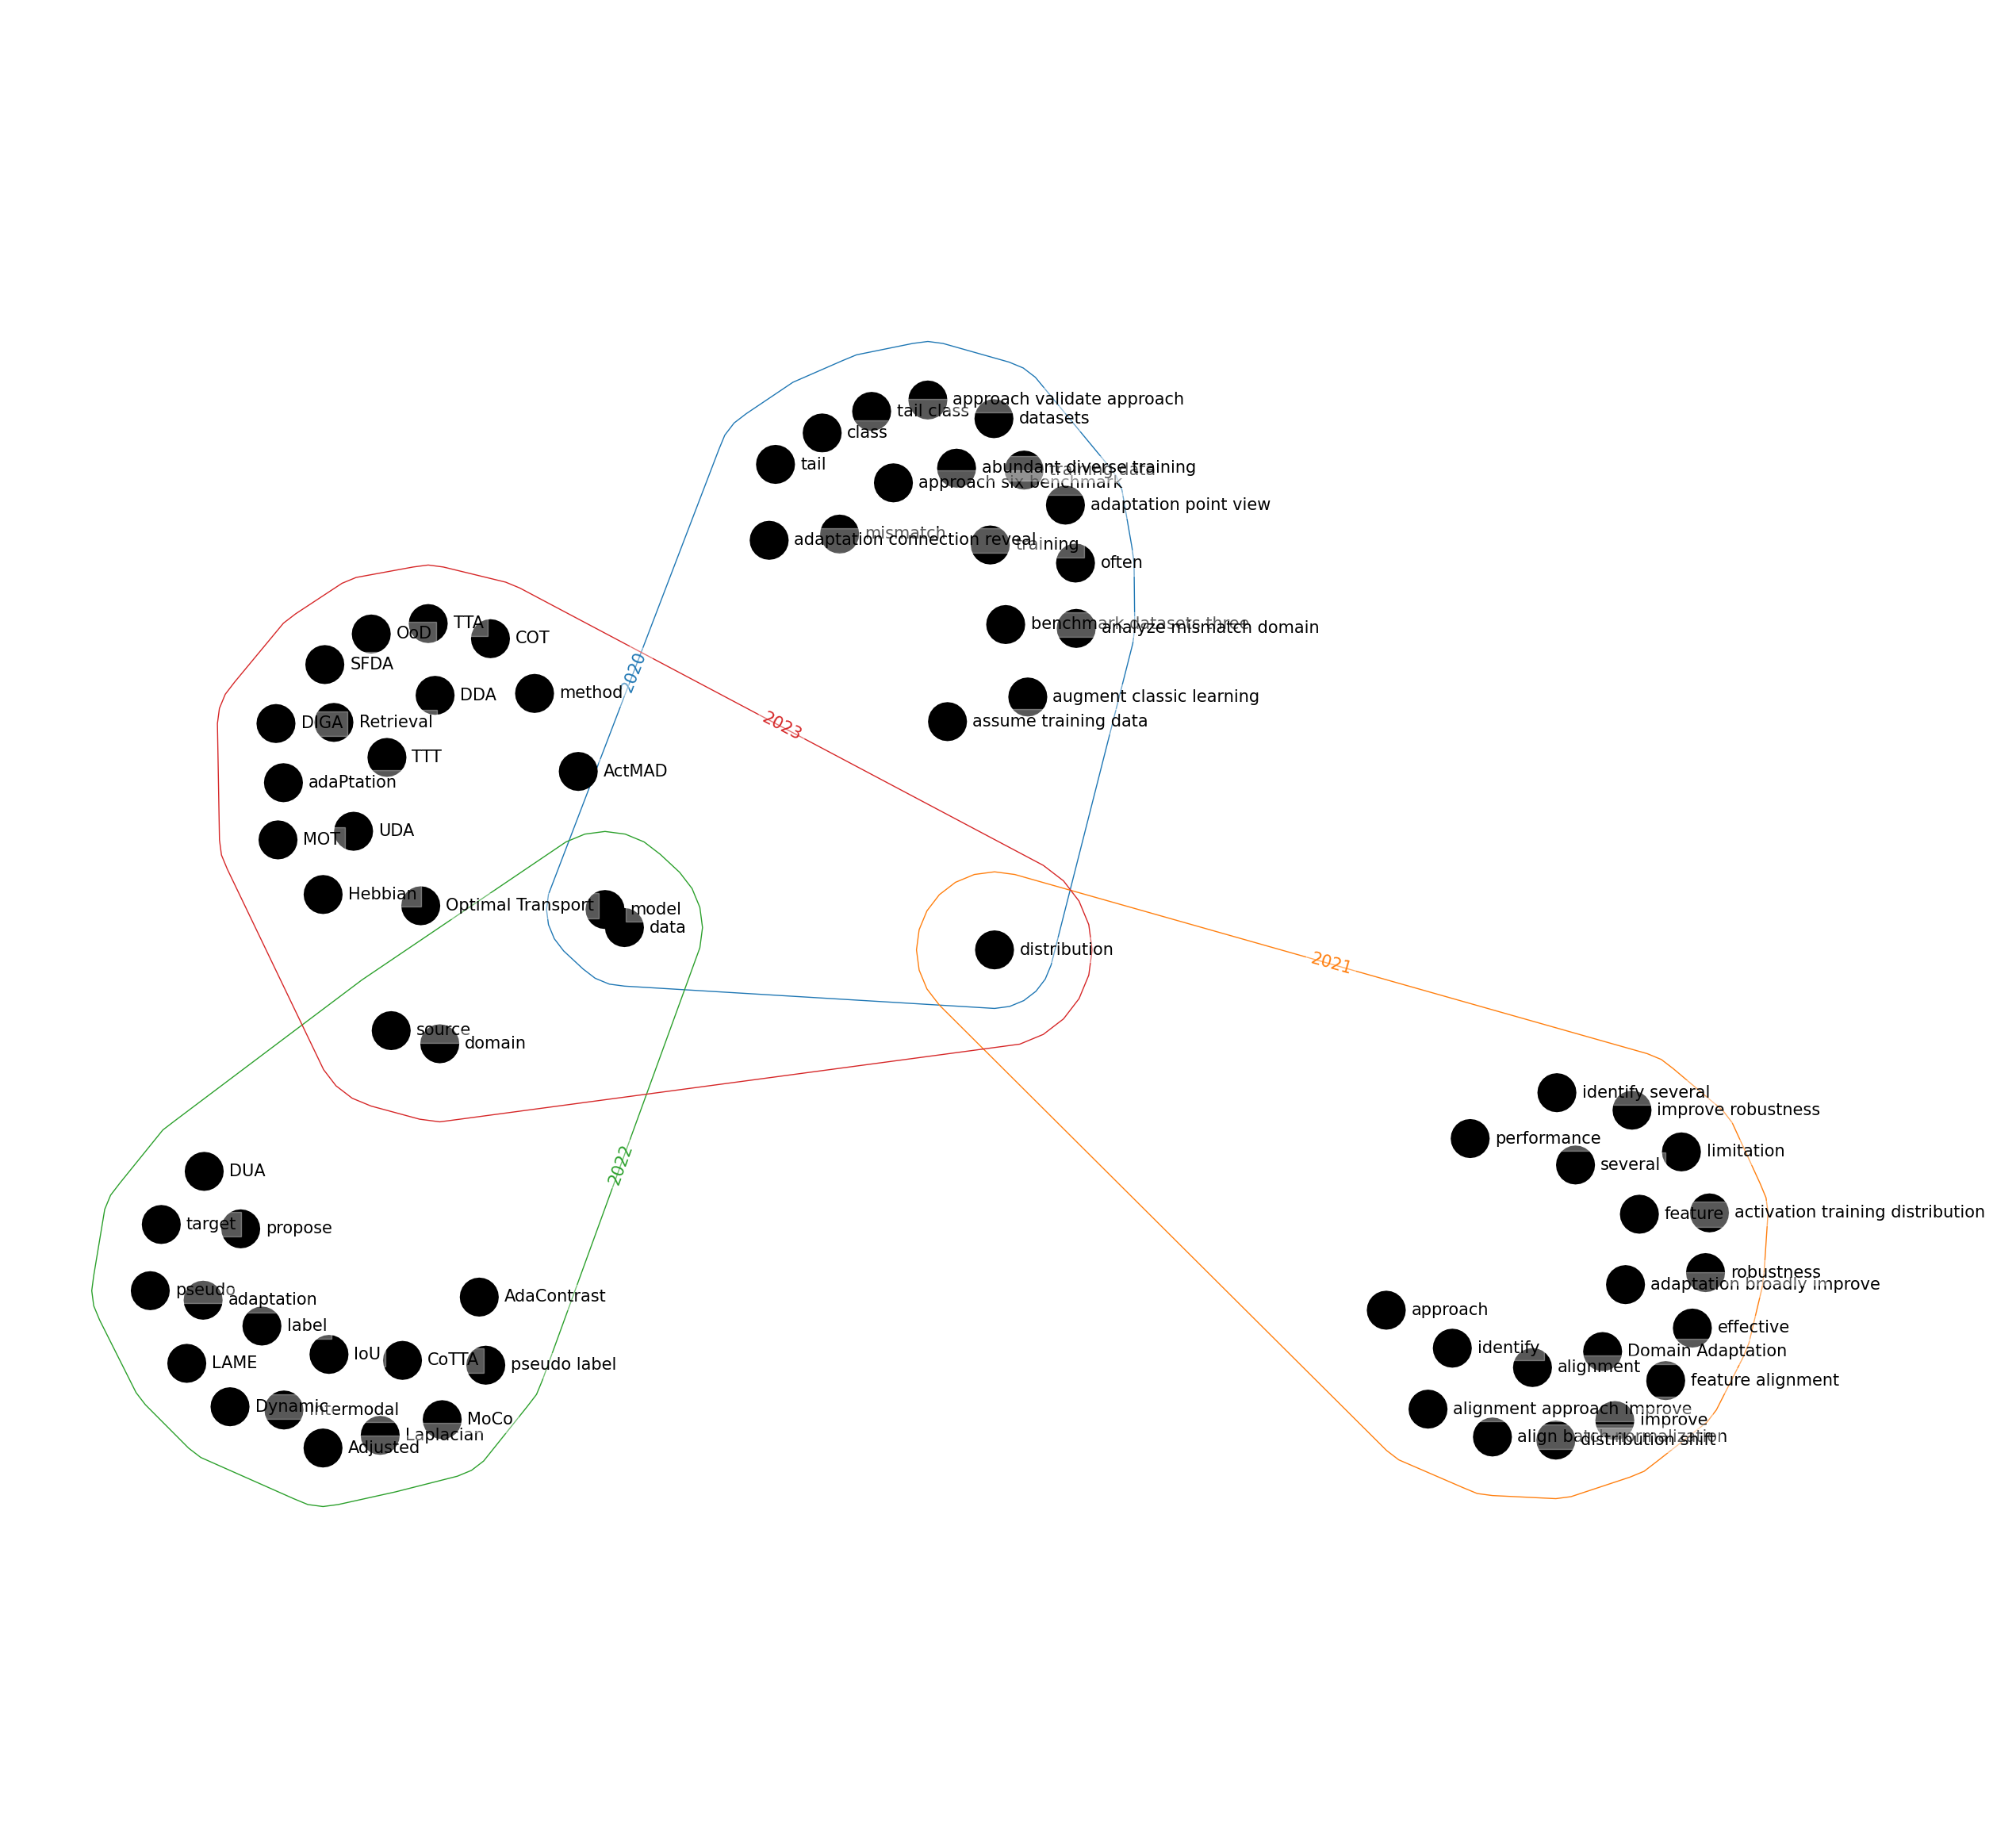

In [8]:
## Method 1
## Adjusting tf-idf scores, give more weights to named-entities and longer phrases

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
from nltk.stem import WordNetLemmatizer
import hypernetx as hnx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Preprocessing text: tokenizing, lemmatizing, removing stopwords, and extracting named entities
def preprocess_and_extract(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Named Entity Recognition with modification
    named_entities = []
    tree = ne_chunk(pos_tags, binary=False)
    previous_word = ""
    for subtree in tree:
        if isinstance(subtree, Tree):  # If the chunk is a named entity
            entity = " ".join([token for token, pos in subtree.leaves()])
            # Skip if entity is capitalized just because it's at the beginning of a sentence
            if entity != entity.upper() and (previous_word.endswith('.') or previous_word == ""):
                continue
            named_entities.append(entity)
        previous_word = subtree[0] if isinstance(subtree, tuple) else ' '.join([token for token, pos in subtree.leaves()])

    # Lemmatization and Stopword Removal
    lemmas = []
    for word, tag in pos_tags:
        if word.lower() not in stop_words:
            wntag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, pos=wntag) if wntag else word
            lemmas.append(lemma)

    # Filter out non-alphabetic tokens and convert to lowercase
    filtered_tokens = [lemma.lower() for lemma in lemmas if lemma.isalpha()]

    return filtered_tokens, named_entities

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


# Function to calculate TF-IDF and extract named entities with special weighting
def extract_keywords_with_tfidf(dataset, num_keywords=25, named_entity_length_factor=8, phrase_length_factor=0.1):
    preprocessed_texts = []
    all_named_entities = defaultdict(list)
    valid_years = []  # To keep track of years with non-empty data

    # Preprocess the text and extract named entities
    for year, text in dataset.items():
        if not text.strip():  # Skip empty text for a year
            continue
        valid_years.append(year)  # Add year to the list of valid years
        tokens, named_entities = preprocess_and_extract(text)
        preprocessed_texts.append(' '.join(tokens))
        all_named_entities[year].extend(named_entities)

    # Calculate TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Consider uni-, bi-, and tri-grams
    tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Map TF-IDF scores to corresponding years and words/phrases
    tfidf_scores = {
        year: dict(zip(feature_names, tfidf_matrix[valid_years.index(year)].toarray().flatten()))
        for year in valid_years
    }

    # Adjust weights for named entities
    for year, entities in all_named_entities.items():
        for entity in entities:
            entity_key = entity.lower()
            if entity_key in tfidf_scores.get(year, {}):
                original_score = tfidf_scores[year][entity_key]
                adjusted_score = original_score * named_entity_length_factor * len(entity.split())
                tfidf_scores[year][entity] = adjusted_score
                del tfidf_scores[year][entity_key]

    # Adjust weights for phrases (n-grams)
    for year, scores in tfidf_scores.items():
        for phrase in list(scores.keys()):
            if len(phrase.split()) > 1:  # It's a phrase
                scores[phrase] *= (1 + phrase_length_factor * (len(phrase.split()) - 1))

    # Extract top keywords based on the combined scores
    top_keywords_by_year = {
        year: sorted(tfidf_scores[year].items(), key=lambda item: item[1], reverse=True)[:num_keywords]
        for year in valid_years
    }

    return top_keywords_by_year


def create_hypergraph(cvpr_data, top_keywords, top_n=20):
    # Create hyperedges from top keywords, ignoring years with empty keyword sets
    hyperedges = {}
    for year, keywords in top_keywords.items():
        if keywords:  # Only include years with non-empty keyword lists
            hyperedges[year] = set([keyword for keyword, score in keywords][:top_n])

    if not hyperedges:  # Check if all years are empty
        print("No keywords available for any year to create a hypergraph.")
        return
        
    # Create hypergraph
    H = hnx.Hypergraph(hyperedges)

    # Set font sizes
    plt.rcParams['font.size'] = 15
    plt.rcParams['axes.labelsize'] = 28
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    # Plot hypergraph
    plt.figure(figsize=(30, 30))
    hnx.draw(H, with_edge_labels=True, layout_kwargs={'seed': 42})
    plt.show()

    return hyperedges

# Example usage with dummy data
data = {
    '2019': ''.join(cvpr_2019.loc[a4['point_indices_within_circle'][49]]['abstract']),
    '2020': ''.join(cvpr_2020.loc[a3['point_indices_within_circle'][49]]['abstract']),
    '2021': ''.join(cvpr_2021.loc[a2['point_indices_within_circle'][49]]['abstract']),
    '2022': ''.join(cvpr_2022.loc[a1['point_indices_within_circle'][49]]['abstract']),
    '2023': ''.join(cvpr_2023.loc[cluster_2023_cvpr['point_indices_within_cluster'][49]]['abstract'])
}

top_keywords = extract_keywords_with_tfidf(data, num_keywords=25, named_entity_length_factor=8, phrase_length_factor=0.1)
for year, keywords in top_keywords.items():
    print(f"Year: {year}")
    for keyword, score in keywords:
        print(f"{keyword}: {score}")
    print()

hyperedges = create_hypergraph(data, top_keywords)

Year: 2019
ILSVRC: 0.25265094203706906
CNet: 0.25265094203706906
PNet: 0.25265094203706906
SNet: 0.25265094203706906
Pointing: 0.25265094203706906
COCO: 0.21350870053108292
LSTM: 0.12632547101853453
Long: 0.10191859460790788
ImageNet: 0.07116956684369431
object: 0.18058429139196647
supervision source: 0.138958018120388
saliency: 0.12632547101853453
class: 0.12454674197646505
supervision: 0.10675435026554146
vocabulary: 0.10675435026554146
train saliency: 0.10421851359029101
weak supervision: 0.10421851359029101
interface: 0.09474410326390091
network: 0.09029214569598323
train: 0.09029214569598323
source: 0.0846016402079488
weak: 0.07643894595593091
give class vocabulary: 0.07579528261112072
saliency detection model: 0.07579528261112072
train saliency detection: 0.07579528261112072

Year: 2020
ZSL: 0.4444152797939263
VOG: 0.35553222383514105
Video Object Grounding: 0.2666491678763558
VOGNet: 0.2666491678763558
Open Images: 0.17776611191757052
ASRL: 0.17776611191757052
CUB: 0.08888305595

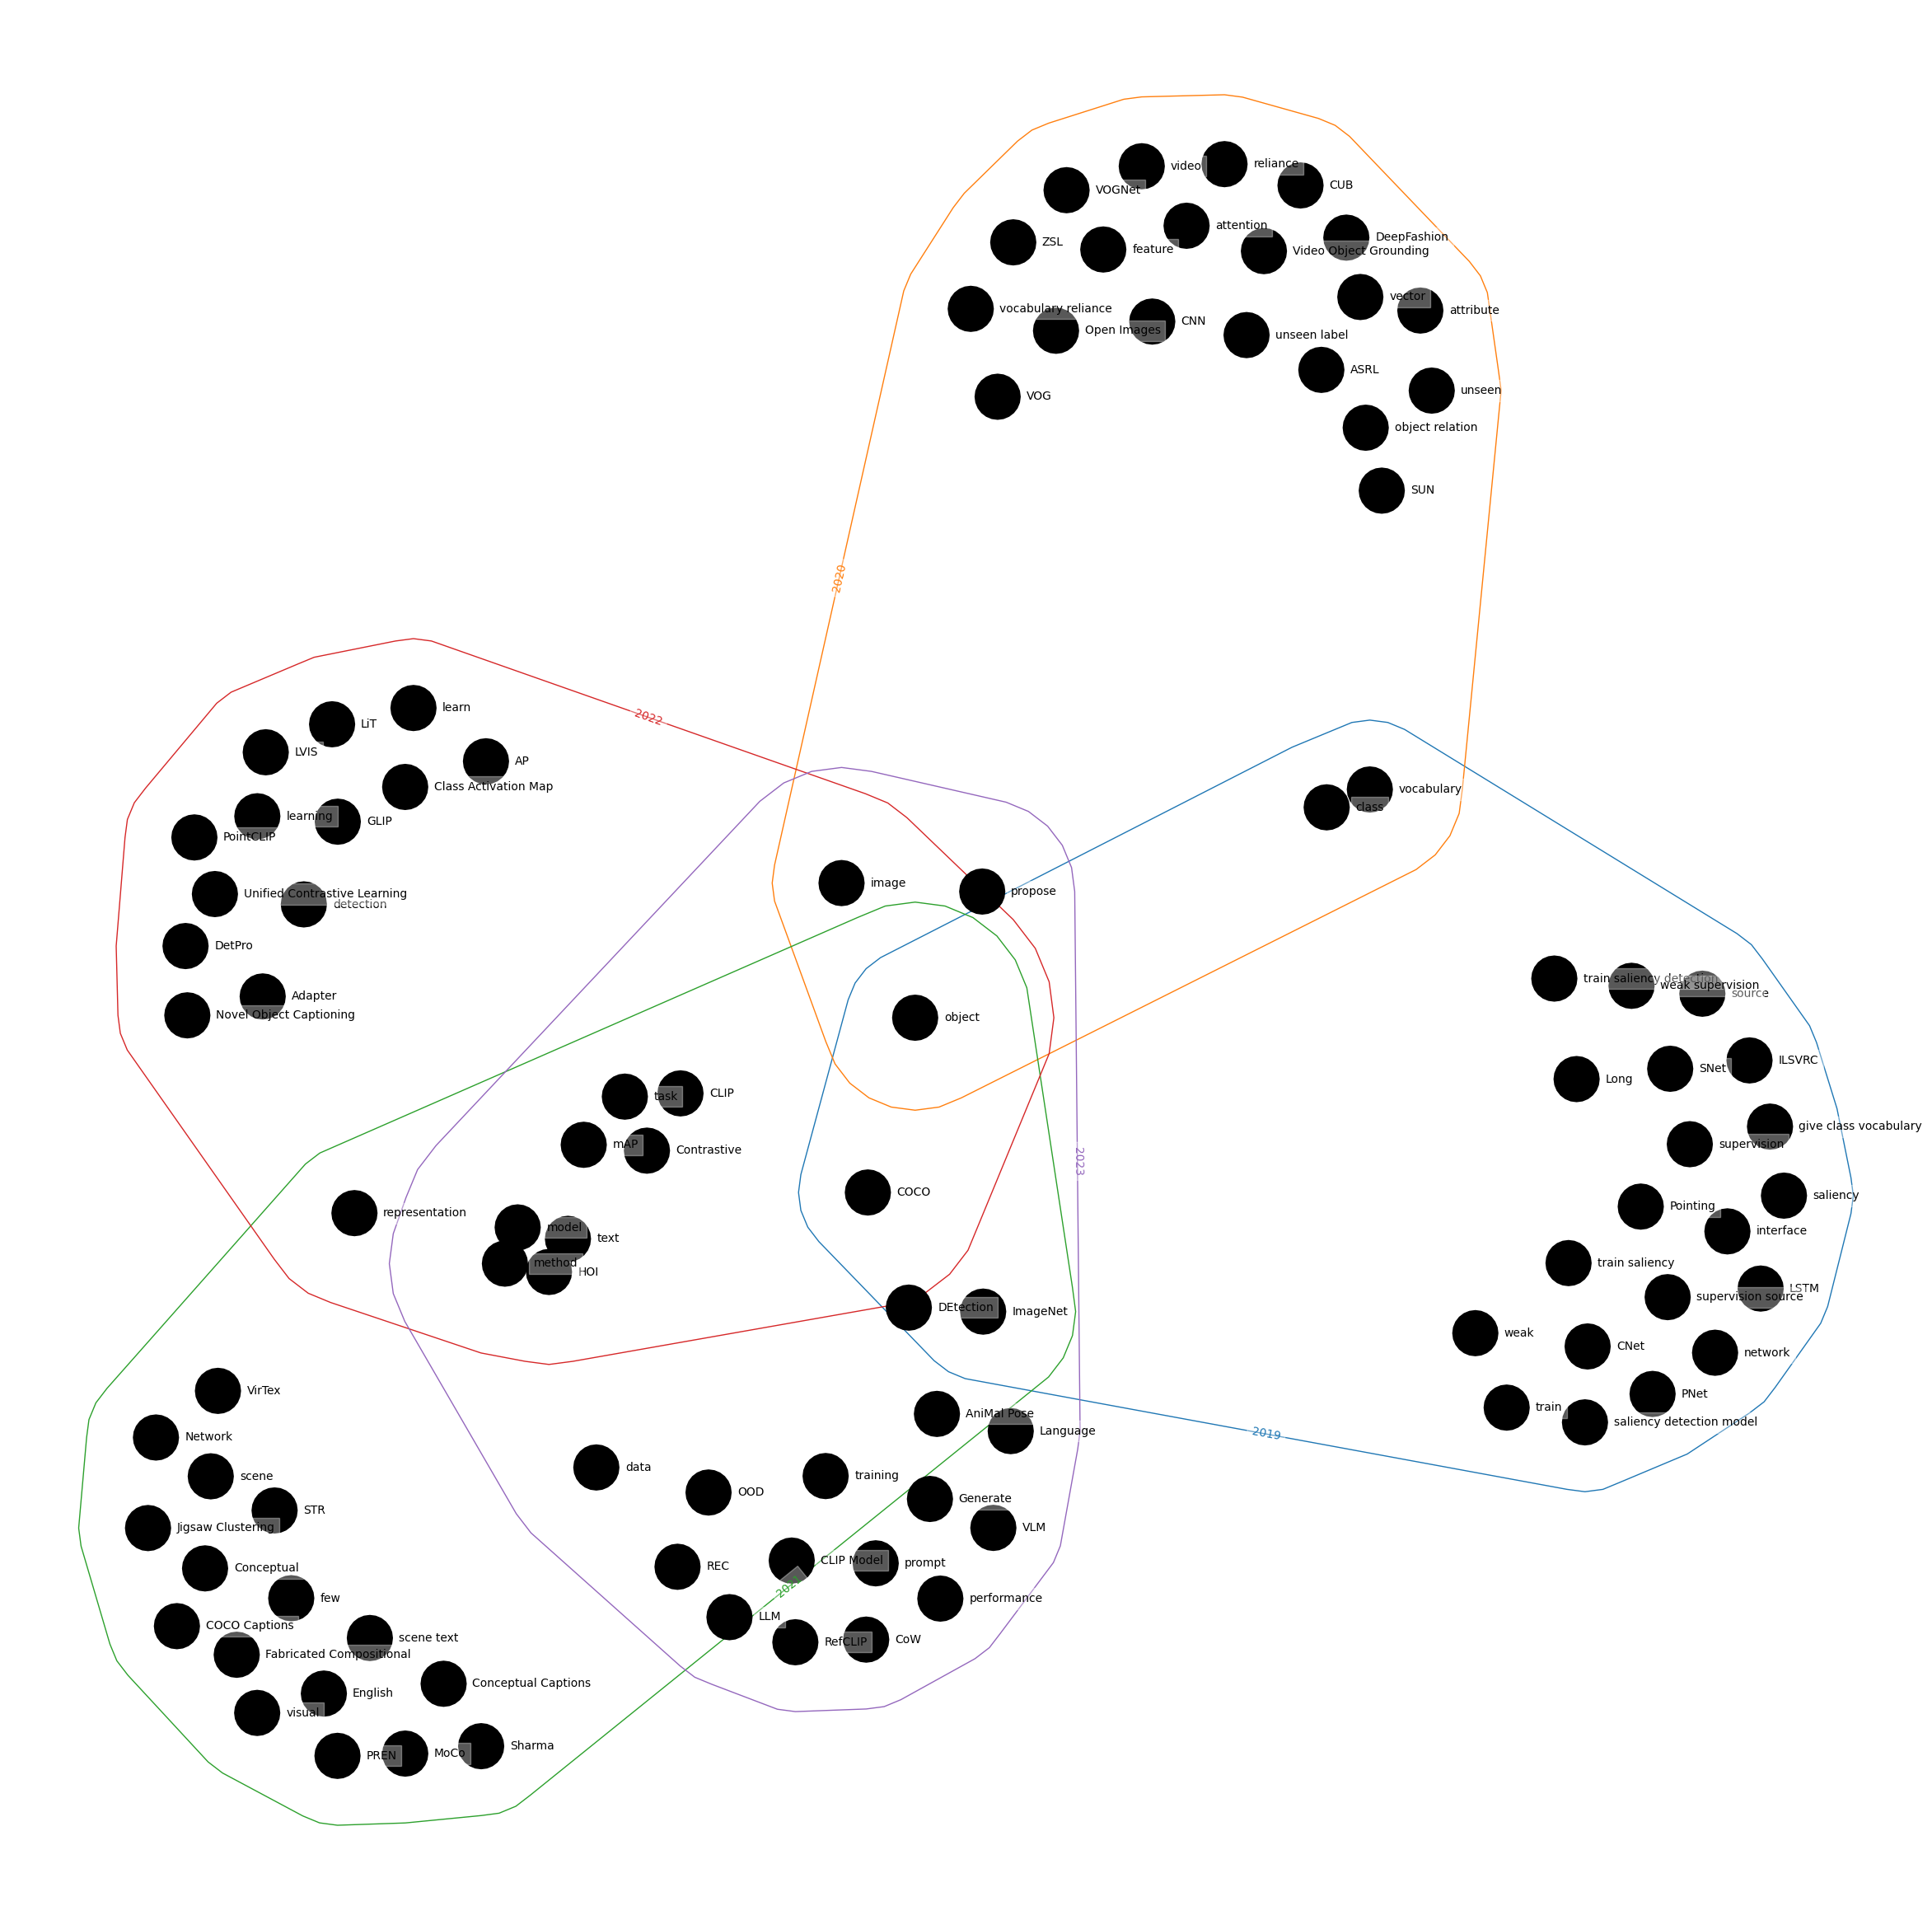

In [9]:
## Method 2
## Set a proportion of named-entities

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
from nltk.stem import WordNetLemmatizer
import hypernetx as hnx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Preprocessing text: tokenizing, lemmatizing, removing stopwords, and extracting named entities
def preprocess_and_extract(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Named Entity Recognition with modification
    named_entities = []
    tree = ne_chunk(pos_tags, binary=False)
    previous_word = ""
    for subtree in tree:
        if isinstance(subtree, Tree):  # If the chunk is a named entity
            entity = " ".join([token for token, pos in subtree.leaves()])
            # Skip if entity is capitalized just because it's at the beginning of a sentence
            if entity != entity.upper() and (previous_word.endswith('.') or previous_word == ""):
                continue
            named_entities.append(entity)
        previous_word = subtree[0] if isinstance(subtree, tuple) else ' '.join([token for token, pos in subtree.leaves()])

    # Lemmatization and Stopword Removal
    lemmas = []
    for word, tag in pos_tags:
        if word.lower() not in stop_words:
            wntag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, pos=wntag) if wntag else word
            lemmas.append(lemma)

    # Filter out non-alphabetic tokens and convert to lowercase
    filtered_tokens = [lemma.lower() for lemma in lemmas if lemma.isalpha()]

    return filtered_tokens, named_entities

# Function to calculate TF-IDF and extract named entities with special weighting

def extract_keywords_with_tfidf(dataset, num_keywords=20, named_entity_proportion=0.5, named_entity_length_factor=1.5, phrase_length_factor=0.1):
    preprocessed_texts = []
    all_named_entities = defaultdict(list)
    valid_years = []  # To keep track of years with non-empty data

    # Preprocess the text and extract named entities
    for year, text in dataset.items():
        if not text.strip():  # Skip empty text for a year
            continue
        valid_years.append(year)  # Add year to the list of valid years
        tokens, named_entities = preprocess_and_extract(text)
        preprocessed_texts.append(' '.join(tokens))
        all_named_entities[year].extend(named_entities)

    # Calculate TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Consider uni-, bi-, and tri-grams
    tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Map TF-IDF scores to corresponding years and words/phrases
    tfidf_scores = {
        year: dict(zip(feature_names, tfidf_matrix[valid_years.index(year)].toarray().flatten()))
        for year in valid_years
    }

    # Process named entities and adjust their weights
    ne_scores = defaultdict(Counter)
    for year, entities in all_named_entities.items():
        for entity in entities:
            entity_key = entity.lower()
            if entity_key in tfidf_scores.get(year, {}):
                original_score = tfidf_scores[year][entity_key]
                adjusted_score = original_score * named_entity_length_factor * len(entity.split())
                ne_scores[year][entity] = adjusted_score
                del tfidf_scores[year][entity_key]

    # Adjust weights for phrases (n-grams)
    for year, scores in tfidf_scores.items():
        for phrase in list(scores.keys()):
            if len(phrase.split()) > 1:  # It's a phrase
                scores[phrase] *= (1 + phrase_length_factor * (len(phrase.split()) - 1))

    # Extract top keywords by combining named entities and TF-IDF scores
    top_keywords_by_year = {}
    for year in valid_years:
        num_ne_keywords = int(num_keywords * named_entity_proportion)
        top_named_entities = sorted(ne_scores[year].items(), key=lambda item: item[1], reverse=True)[:num_ne_keywords]
        remaining_keywords = num_keywords - len(top_named_entities)
        top_tfidf_keywords = sorted(tfidf_scores[year].items(), key=lambda item: item[1], reverse=True)[:remaining_keywords]
        top_keywords_by_year[year] = top_named_entities + top_tfidf_keywords

    return top_keywords_by_year


# Helper functions (get_wordnet_pos etc.) and example usage remain the same as in your original code
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None



def create_hypergraph(cvpr_data, top_keywords):
    # Create hyperedges from top keywords
    hyperedges = {}
    for year, keywords in top_keywords.items():
        hyperedges[year] = set([keyword for keyword, score in keywords])

    # Create hypergraph
    H = hnx.Hypergraph(hyperedges)

    # Set font sizes
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelsize'] = 28
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10


    # Plot hypergraph
    plt.figure(figsize=(30, 30))
    hnx.draw(H, with_edge_labels=True)#, layout_kwargs={'seed': 42})

    
    plt.show()

   
    return hyperedges

# Example usage with dummy data
data = {
    '2019': ''.join(cvpr_2019.loc[a4['point_indices_within_circle'][31]]['abstract']),
    '2020': ''.join(cvpr_2020.loc[a3['point_indices_within_circle'][31]]['abstract']),
    '2021': ''.join(cvpr_2021.loc[a2['point_indices_within_circle'][31]]['abstract']),
    '2022': ''.join(cvpr_2022.loc[a1['point_indices_within_circle'][31]]['abstract']),
    '2023': ''.join(cvpr_2023.loc[cluster_2023_cvpr['point_indices_within_cluster'][31]]['abstract'])
}

top_keywords = extract_keywords_with_tfidf(data, num_keywords=25,named_entity_proportion=0.6, named_entity_length_factor=4, phrase_length_factor=0.1)
for year, keywords in top_keywords.items():
    print(f"Year: {year}")
    for keyword, score in keywords:
        print(f"{keyword}: {score}")
    print()

hyperedges = create_hypergraph(data, top_keywords)

Year: 2020
Distributed Asynchronized: 0.283885532821806
AsynDGAN: 0.283885532821806
GAN: 0.22381861482165336
Differential Privacy: 0.14814324783805774
weight: 0.18120045826386305
train: 0.1728337891444007
compare model train: 0.1135542131287224
real: 0.11190930741082668
could learn: 0.10409136203466221
use train: 0.10409136203466221
deep: 0.09876216522537183
learn: 0.09876216522537183
probe: 0.094628510940602
distributed: 0.09060022913193153
forget: 0.09060022913193153
use: 0.09060022913193153
compare model: 0.08206682543460624
discriminator: 0.07460620494055112
generator: 0.07460620494055112
particular: 0.07460620494055112
model: 0.07407162391902887
network: 0.07407162391902887
deep neural: 0.06644016803008314
could: 0.060400152754621024
efficient: 0.060400152754621024

Year: 2021
FL: 0.46748739930204364
Continuous Frequency Space: 0.4394456086145829
MOON: 0.2929637390763886
DP: 0.2804924395812262
Episodic Learning: 0.1464818695381943
DLG: 0.1464818695381943
GS: 0.1464818695381943
ELC

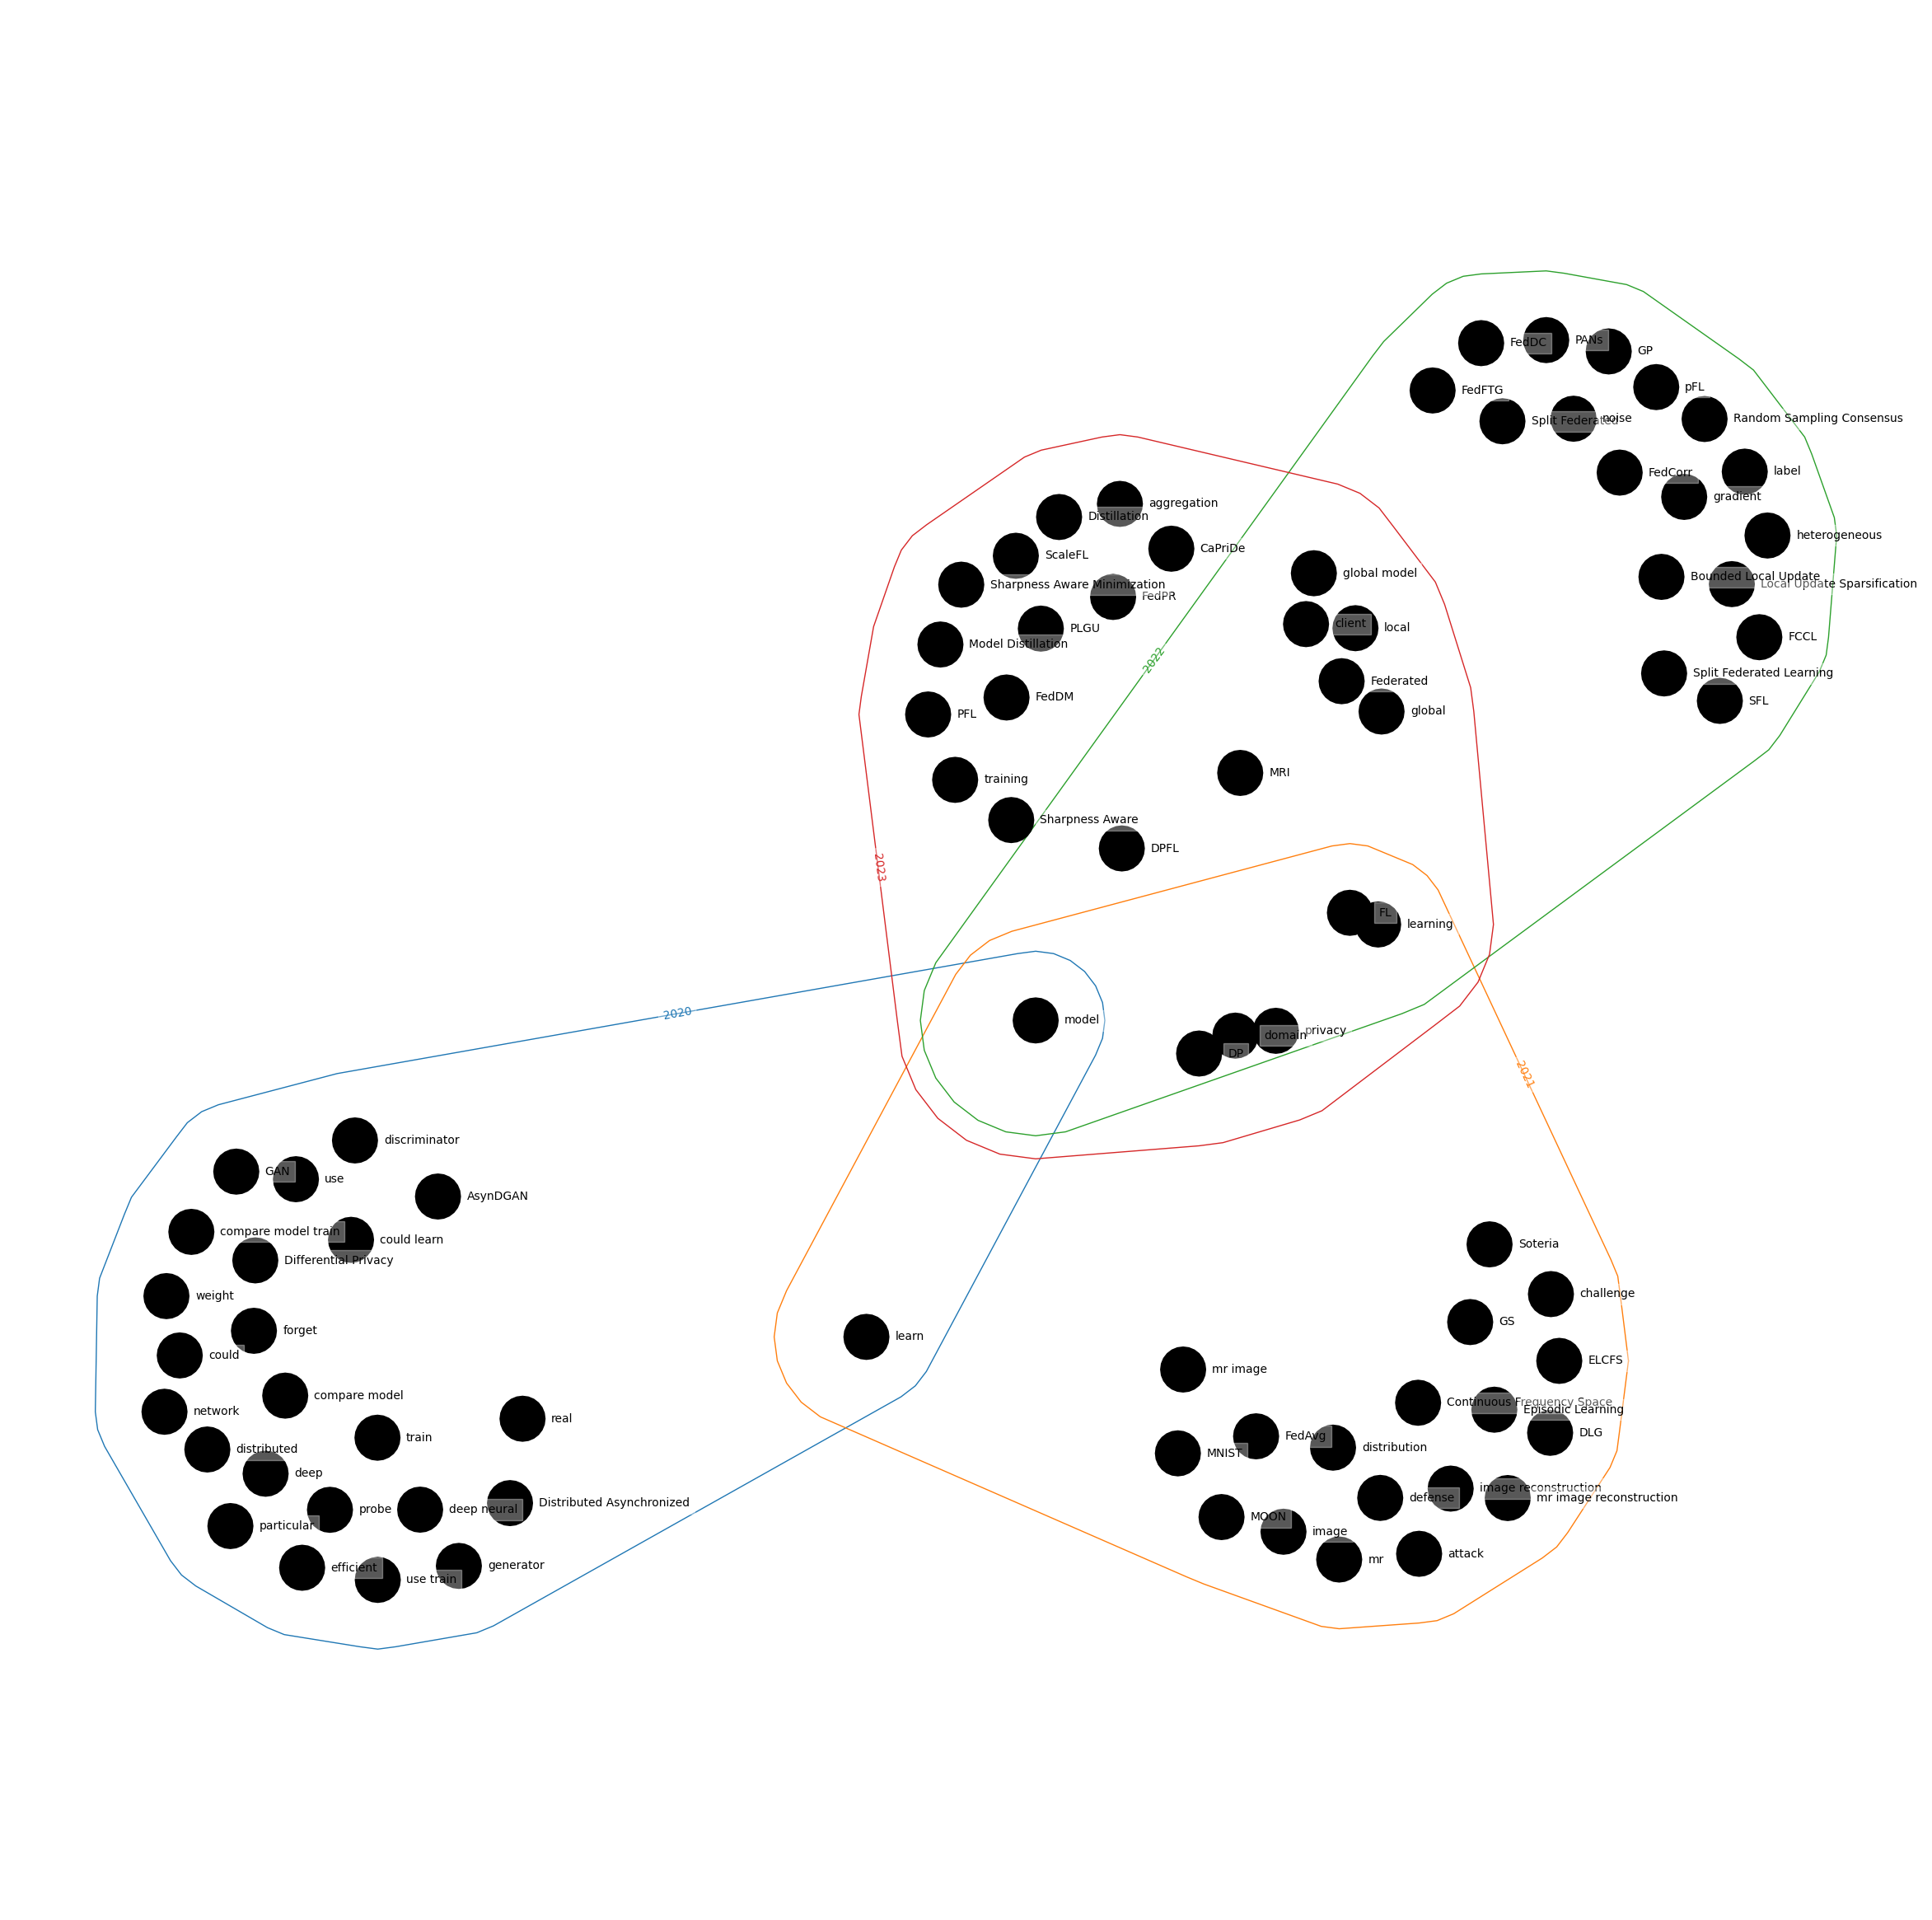

In [10]:
## Method 2 (Mofidied, add some words to exclude from keywords)
## Set a proportion of named-entities

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
from nltk.stem import WordNetLemmatizer
import hypernetx as hnx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize


# List of words to exclude from keyword extraction
exclusion_list = ['propose', 'method', 'task', 'approach', 'algorithm', 'system', 'technique', 'framework', 'performance', 'result', 'analysis', 'study', 'research', 'data', 'work', 'paper', 'findings', 'discussion', 'conclusion']


# Preprocessing text: tokenizing, lemmatizing, removing stopwords, and extracting named entities
def preprocess_and_extract(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Named Entity Recognition with modification
    named_entities = []
    tree = ne_chunk(pos_tags, binary=False)
    previous_word = ""
    for subtree in tree:
        if isinstance(subtree, Tree):  # If the chunk is a named entity
            entity = " ".join([token for token, pos in subtree.leaves()])
            # Skip if entity is capitalized just because it's at the beginning of a sentence
            if entity != entity.upper() and (previous_word.endswith('.') or previous_word == ""):
                continue
            named_entities.append(entity)
        previous_word = subtree[0] if isinstance(subtree, tuple) else ' '.join([token for token, pos in subtree.leaves()])

    # Lemmatization and Stopword Removal
    lemmas = []
    for word, tag in pos_tags:
        if word.lower() not in stop_words:
            wntag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, pos=wntag) if wntag else word
            lemmas.append(lemma)

    # Filter out non-alphabetic tokens and convert to lowercase
    filtered_tokens = [lemma.lower() for lemma in lemmas if lemma.isalpha()]

    return filtered_tokens, named_entities

# Function to calculate TF-IDF and extract named entities with special weighting

def extract_keywords_with_tfidf(dataset, num_keywords=25, named_entity_proportion=0.5, named_entity_length_factor=1.5, phrase_length_factor=0.1):
    preprocessed_texts = []
    all_named_entities = defaultdict(list)
    valid_years = []

    # Preprocess the text and extract named entities
    for year, text in dataset.items():
        if text.strip():  # Check if text is not empty
            tokens, named_entities = preprocess_and_extract(text)
            preprocessed_texts.append(' '.join(tokens))
            all_named_entities[year].extend(named_entities)
            valid_years.append(year)

    # Calculate TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words=exclusion_list)
    tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Map TF-IDF scores to corresponding years and words/phrases
    tfidf_scores = {}
    for idx, year in enumerate(valid_years):
        tfidf_scores[year] = dict(zip(feature_names, tfidf_matrix[idx].toarray().flatten()))

    # Process named entities and adjust their weights
    ne_scores = defaultdict(Counter)
    for year, entities in all_named_entities.items():
        for entity in entities:
            entity_key = entity.lower()
            if entity_key in tfidf_scores[year]:
                original_score = tfidf_scores[year][entity_key]
                adjusted_score = original_score * named_entity_length_factor * len(entity.split())
                ne_scores[year][entity] = adjusted_score
                del tfidf_scores[year][entity_key]

    # Adjust weights for phrases (n-grams)
    for year, scores in tfidf_scores.items():
        for phrase in list(scores.keys()):
            if len(phrase.split()) > 1:  # It's a phrase
                scores[phrase] *= (1 + phrase_length_factor * (len(phrase.split()) - 1))

    # Extract top keywords by combining named entities and TF-IDF scores
    top_keywords_by_year = {}
    for year in valid_years:
        num_ne_keywords = int(num_keywords * named_entity_proportion)
        top_named_entities = sorted(ne_scores[year].items(), key=lambda item: item[1], reverse=True)[:num_ne_keywords]
        remaining_keywords = num_keywords - len(top_named_entities)
        top_tfidf_keywords = sorted(tfidf_scores[year].items(), key=lambda item: item[1], reverse=True)[:remaining_keywords]
        top_keywords_by_year[year] = top_named_entities + top_tfidf_keywords
    
    return top_keywords_by_year



# Helper functions (get_wordnet_pos etc.) and example usage remain the same as in your original code
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None



def create_hypergraph(cvpr_data, top_keywords):
    # Create hyperedges from top keywords
    hyperedges = {}
    for year, keywords in top_keywords.items():
        if year in cvpr_data and cvpr_data[year].strip():  # Check if the year has data
            hyperedges[year] = set([keyword for keyword, score in keywords])

    # Create hypergraph
    H = hnx.Hypergraph(hyperedges)

    # Set font sizes
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelsize'] = 28
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10


    # Plot hypergraph
    plt.figure(figsize=(30, 30))
    hnx.draw(H, with_edge_labels=True)#, layout_kwargs={'seed': 42})

    
    plt.show()

   
    return hyperedges

# Example usage with dummy data
data = {
    '2019': ''.join(cvpr_2019.loc[a4['point_indices_within_circle'][45]]['abstract']),
    '2020': ''.join(cvpr_2020.loc[a3['point_indices_within_circle'][45]]['abstract']),
    '2021': ''.join(cvpr_2021.loc[a2['point_indices_within_circle'][45]]['abstract']),
    '2022': ''.join(cvpr_2022.loc[a1['point_indices_within_circle'][45]]['abstract']),
    '2023': ''.join(cvpr_2023.loc[cluster_2023_cvpr['point_indices_within_cluster'][45]]['abstract'])
}

top_keywords = extract_keywords_with_tfidf(data, num_keywords=25, named_entity_proportion=0.6, named_entity_length_factor=3, phrase_length_factor=0.1)
for year, keywords in top_keywords.items():
    print(f"Year: {year}")
    for keyword, score in keywords:
        print(f"{keyword}: {score}")
    print()

hyperedges = create_hypergraph(data, top_keywords)

Year: 2019
ILSVRC: 0.1945213457854214
CNet: 0.1945213457854214
PNet: 0.1945213457854214
SNet: 0.1945213457854214
Pointing: 0.1945213457854214
COCO: 0.1643848996933848
LSTM: 0.0972606728927107
Long: 0.07846929848684378
ImageNet: 0.0547949665644616
object: 0.18538092704000597
supervision source: 0.14264898690930905
saliency: 0.12968089719028095
class: 0.12785492198374374
supervision: 0.10958993312892319
vocabulary: 0.10958993312892319
train saliency: 0.1069867401819818
weak supervision: 0.1069867401819818
interface: 0.09726067289271072
network: 0.09269046352000299
train: 0.09269046352000299
source: 0.08684880822115791
weak: 0.07846929848684377
give class vocabulary: 0.07780853831416856
saliency detection model: 0.07780853831416856
train saliency detection: 0.07780853831416856

Year: 2020
ZSL: 0.34302843257688487
VOG: 0.27442274606150785
Video Object Grounding: 0.2058170595461309
VOGNet: 0.2058170595461309
Open Images: 0.13721137303075392
ASRL: 0.13721137303075392
CUB: 0.06860568651537696

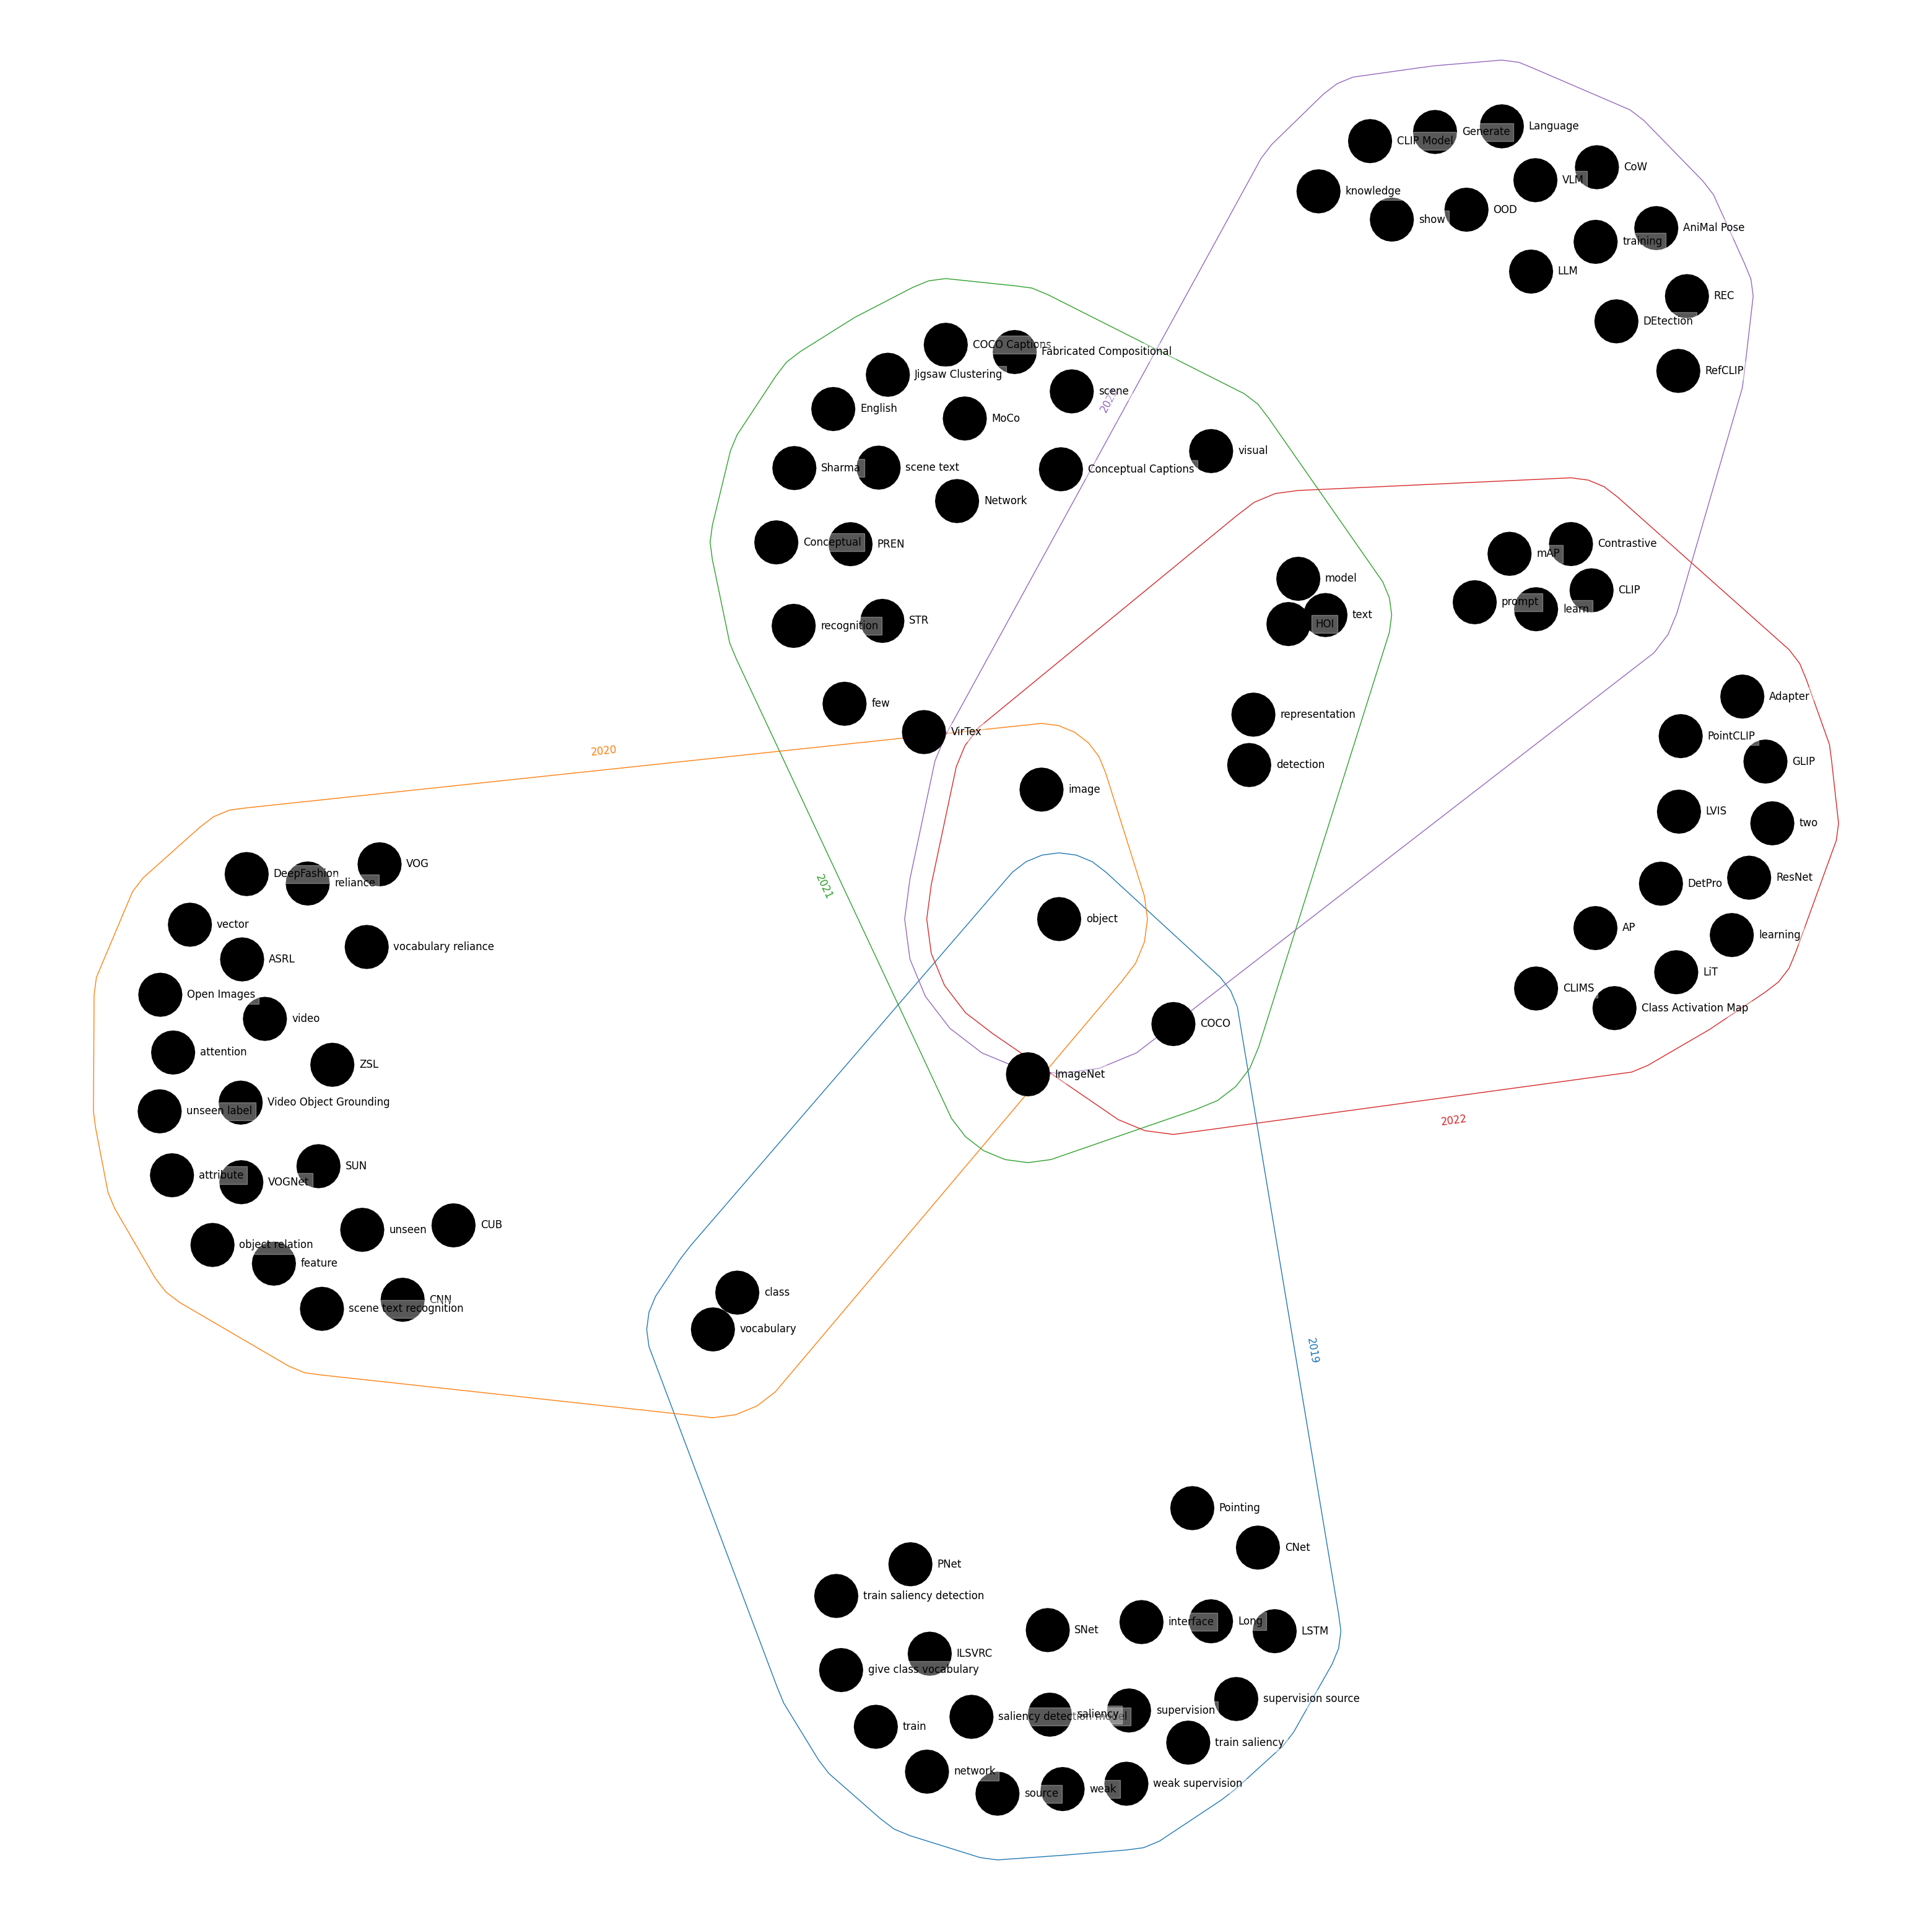

In [11]:

import matplotlib.pyplot as plt
import hypernetx as hnx

def create_hypergraph(cvpr_data, top_keywords):
    hyperedges = {}
    for year, keywords in top_keywords.items():
        if year in cvpr_data and cvpr_data[year].strip():  # Check if the year has data
            hyperedges[year] = set([keyword for keyword, score in keywords])

    # ... [your existing code to create hyperedges remains unchanged]

    # Create hypergraph
    H = hnx.Hypergraph(hyperedges)

    # Set font sizes larger to improve readability
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    # Scale up the figure size to spread out points
    fig, ax = plt.subplots(figsize=(40, 40))  # Increase the figure size

    # Draw the hypergraph
    hnx.draw(H, ax=ax, with_edge_labels=True)

    # Optionally, adjust the text position for each node to reduce overlap
    for text in ax.texts:
        text.set_position((text.get_position()[0] * 1.1, text.get_position()[1] * 1.1))

    # Show the plot
    plt.show()

    return hyperedges



# Example usage with dummy data
data = {
    '2019': ''.join(cvpr_2019.loc[a4['point_indices_within_circle'][31]]['abstract']),
    '2020': ''.join(cvpr_2020.loc[a3['point_indices_within_circle'][31]]['abstract']),
    '2021': ''.join(cvpr_2021.loc[a2['point_indices_within_circle'][31]]['abstract']),
    '2022': ''.join(cvpr_2022.loc[a1['point_indices_within_circle'][31]]['abstract']),
    '2023': ''.join(cvpr_2023.loc[cluster_2023_cvpr['point_indices_within_cluster'][31]]['abstract'])
}

top_keywords = extract_keywords_with_tfidf(data, num_keywords=25, named_entity_proportion=0.6, named_entity_length_factor=3, phrase_length_factor=0.1)
for year, keywords in top_keywords.items():
    print(f"Year: {year}")
    for keyword, score in keywords:
        print(f"{keyword}: {score}")
    print()

hyperedges = create_hypergraph(data, top_keywords)

## ICML

In [33]:
b1 = assign_points_and_find_within_radius("2022_icml_abstracts.json", cluster_2023_icml['cluster_center'], cluster_2023_icml['radius'])
b2 = assign_points_and_find_within_radius("2021_icml_abstracts.json", cluster_2023_icml['cluster_center'], cluster_2023_icml['radius'])
b3 = assign_points_and_find_within_radius("2020_icml_abstracts.json", cluster_2023_icml['cluster_center'], cluster_2023_icml['radius'])
b4 = assign_points_and_find_within_radius("2019_icml_abstracts.json", cluster_2023_icml['cluster_center'], cluster_2023_icml['radius'])

icml_2023 = pd.read_json("2023_icml_abstracts.json")
icml_2019 = pd.read_json("2019_icml_abstracts.json")
icml_2020 = pd.read_json("2020_icml_abstracts.json")
icml_2021 = pd.read_json("2021_icml_abstracts.json")
icml_2022 = pd.read_json("2022_icml_abstracts.json")

icml = pd.concat([icml_2023, icml_2022, icml_2021, icml_2020, icml_2019], ignore_index=True)


In [34]:
import pandas as pd
combined_df_icml = pd.concat([cluster_2023_icml['cluster_center'],
                         b1['Topic Shift'],b2['Topic Shift'],b3['Topic Shift'],b4['Topic Shift'],
                              cluster_2023_icml['sum_of_similarities'],
                         b1['sum_of_similarities_within_circle'],b2['sum_of_similarities_within_circle'],b3['sum_of_similarities_within_circle'],b4['sum_of_similarities_within_circle'],
                         ], axis=1)

combined_df_icml.columns = ['cluster_center_2023_icml',
                            'Topic Shift_2022','Topic Shift_2021','Topic Shift_2020','Topic Shift_2019',
                            '2023_sum_of_similarities','2022_sum_of_similarities', '2021_sum_of_similarities','2020_sum_of_similarities','2019_sum_of_similarities',
                            ]

In [35]:
combined_df_icml.loc[[25,34,37,38,47,48,49]]

cluster_center_2023_icml  Topic Shift_2022  \
25  [-0.04412102699279785, -0.09038114547729492, 0...          0.442044   
34  [-0.05660378932952881, -0.04482503607869148, 0...          0.395634   
37  [-0.05630364269018173, -0.06813632696866989, 0...          0.262256   
38  [-0.06776442378759384, -0.05003412440419197, 0...          0.220503   
47  [-0.06584355235099792, -0.054548539221286774, ...          0.405190   
48  [-0.06471577286720276, -0.0994550883769989, 0....          0.284178   
49  [-0.08084096014499664, 0.0069666169583797455, ...          0.452749   

    Topic Shift_2021  Topic Shift_2020  Topic Shift_2019  \
25          0.387999          0.640436          0.628758   
34          0.338592          0.315765          0.383599   
37          0.277122          0.299828          0.473509   
38          0.330102          0.439262          0.447414   
47          0.567742          0.532082          0.837625   
48          0.394805          0.580832          0.803279   
49          0.393159          0.568750          0.576644   

    2023_sum_of_similarities  2022_sum_of_similarities  \
25                 21.586041                  1.723883   
34                 16.912067                  2.318863   
37                 15.348213                  6.075628   
38                 15.088233                  8.180785   
47                  9.986859                  2.354797   
48                 10.032893                  4.655189   
49                  7.850368                  1.764247   

    2021_sum_of_similarities  2020_sum_of_similarities  \
25                  2.303273                  1.117622   
34                  5.119087                  5.105682   
37                  4.765512                  5.339292   
38                  2.326602                  2.311460   
47                  0.617058                  1.121324   
48                  2.922067                  0.574552   
49                  1.795158                  0.569625   

    2019_sum_of_similarities  
25                  1.127886  
34                  3.387843  
37                  1.721860  
38                  1.177772  
47                  0.544181  
48                  0.554545  
49                  0.634259

Year: 2019
Clarkson: 0.6322000249372204
algorithm: 0.15062334961796298
classical: 0.11296751221347223
quantum: 0.11296751221347223
also: 0.1058479311772121
optimal: 0.1058479311772121
run: 0.1058479311772121
quantum algorithm: 0.0899330427709642
use: 0.08904261660491505
al run also: 0.0806055031794956
algorithm classification fundamental: 0.0806055031794956
algorithm task run: 0.0806055031794956
algorithm train classifier: 0.0806055031794956
algorithm use standard: 0.0806055031794956
also demonstrate tight: 0.0806055031794956
also optimal model: 0.0806055031794956
application also demonstrate: 0.0806055031794956
bound factor discuss: 0.0806055031794956
clarkson et al: 0.0806055031794956
classical algorithm train: 0.0806055031794956
classical input generate: 0.0806055031794956
classical output suggest: 0.0806055031794956
classification fundamental problem: 0.0806055031794956
classifier constant margin: 0.0806055031794956
constant margin clarkson: 0.0806055031794956

Year: 2020
Mixture M

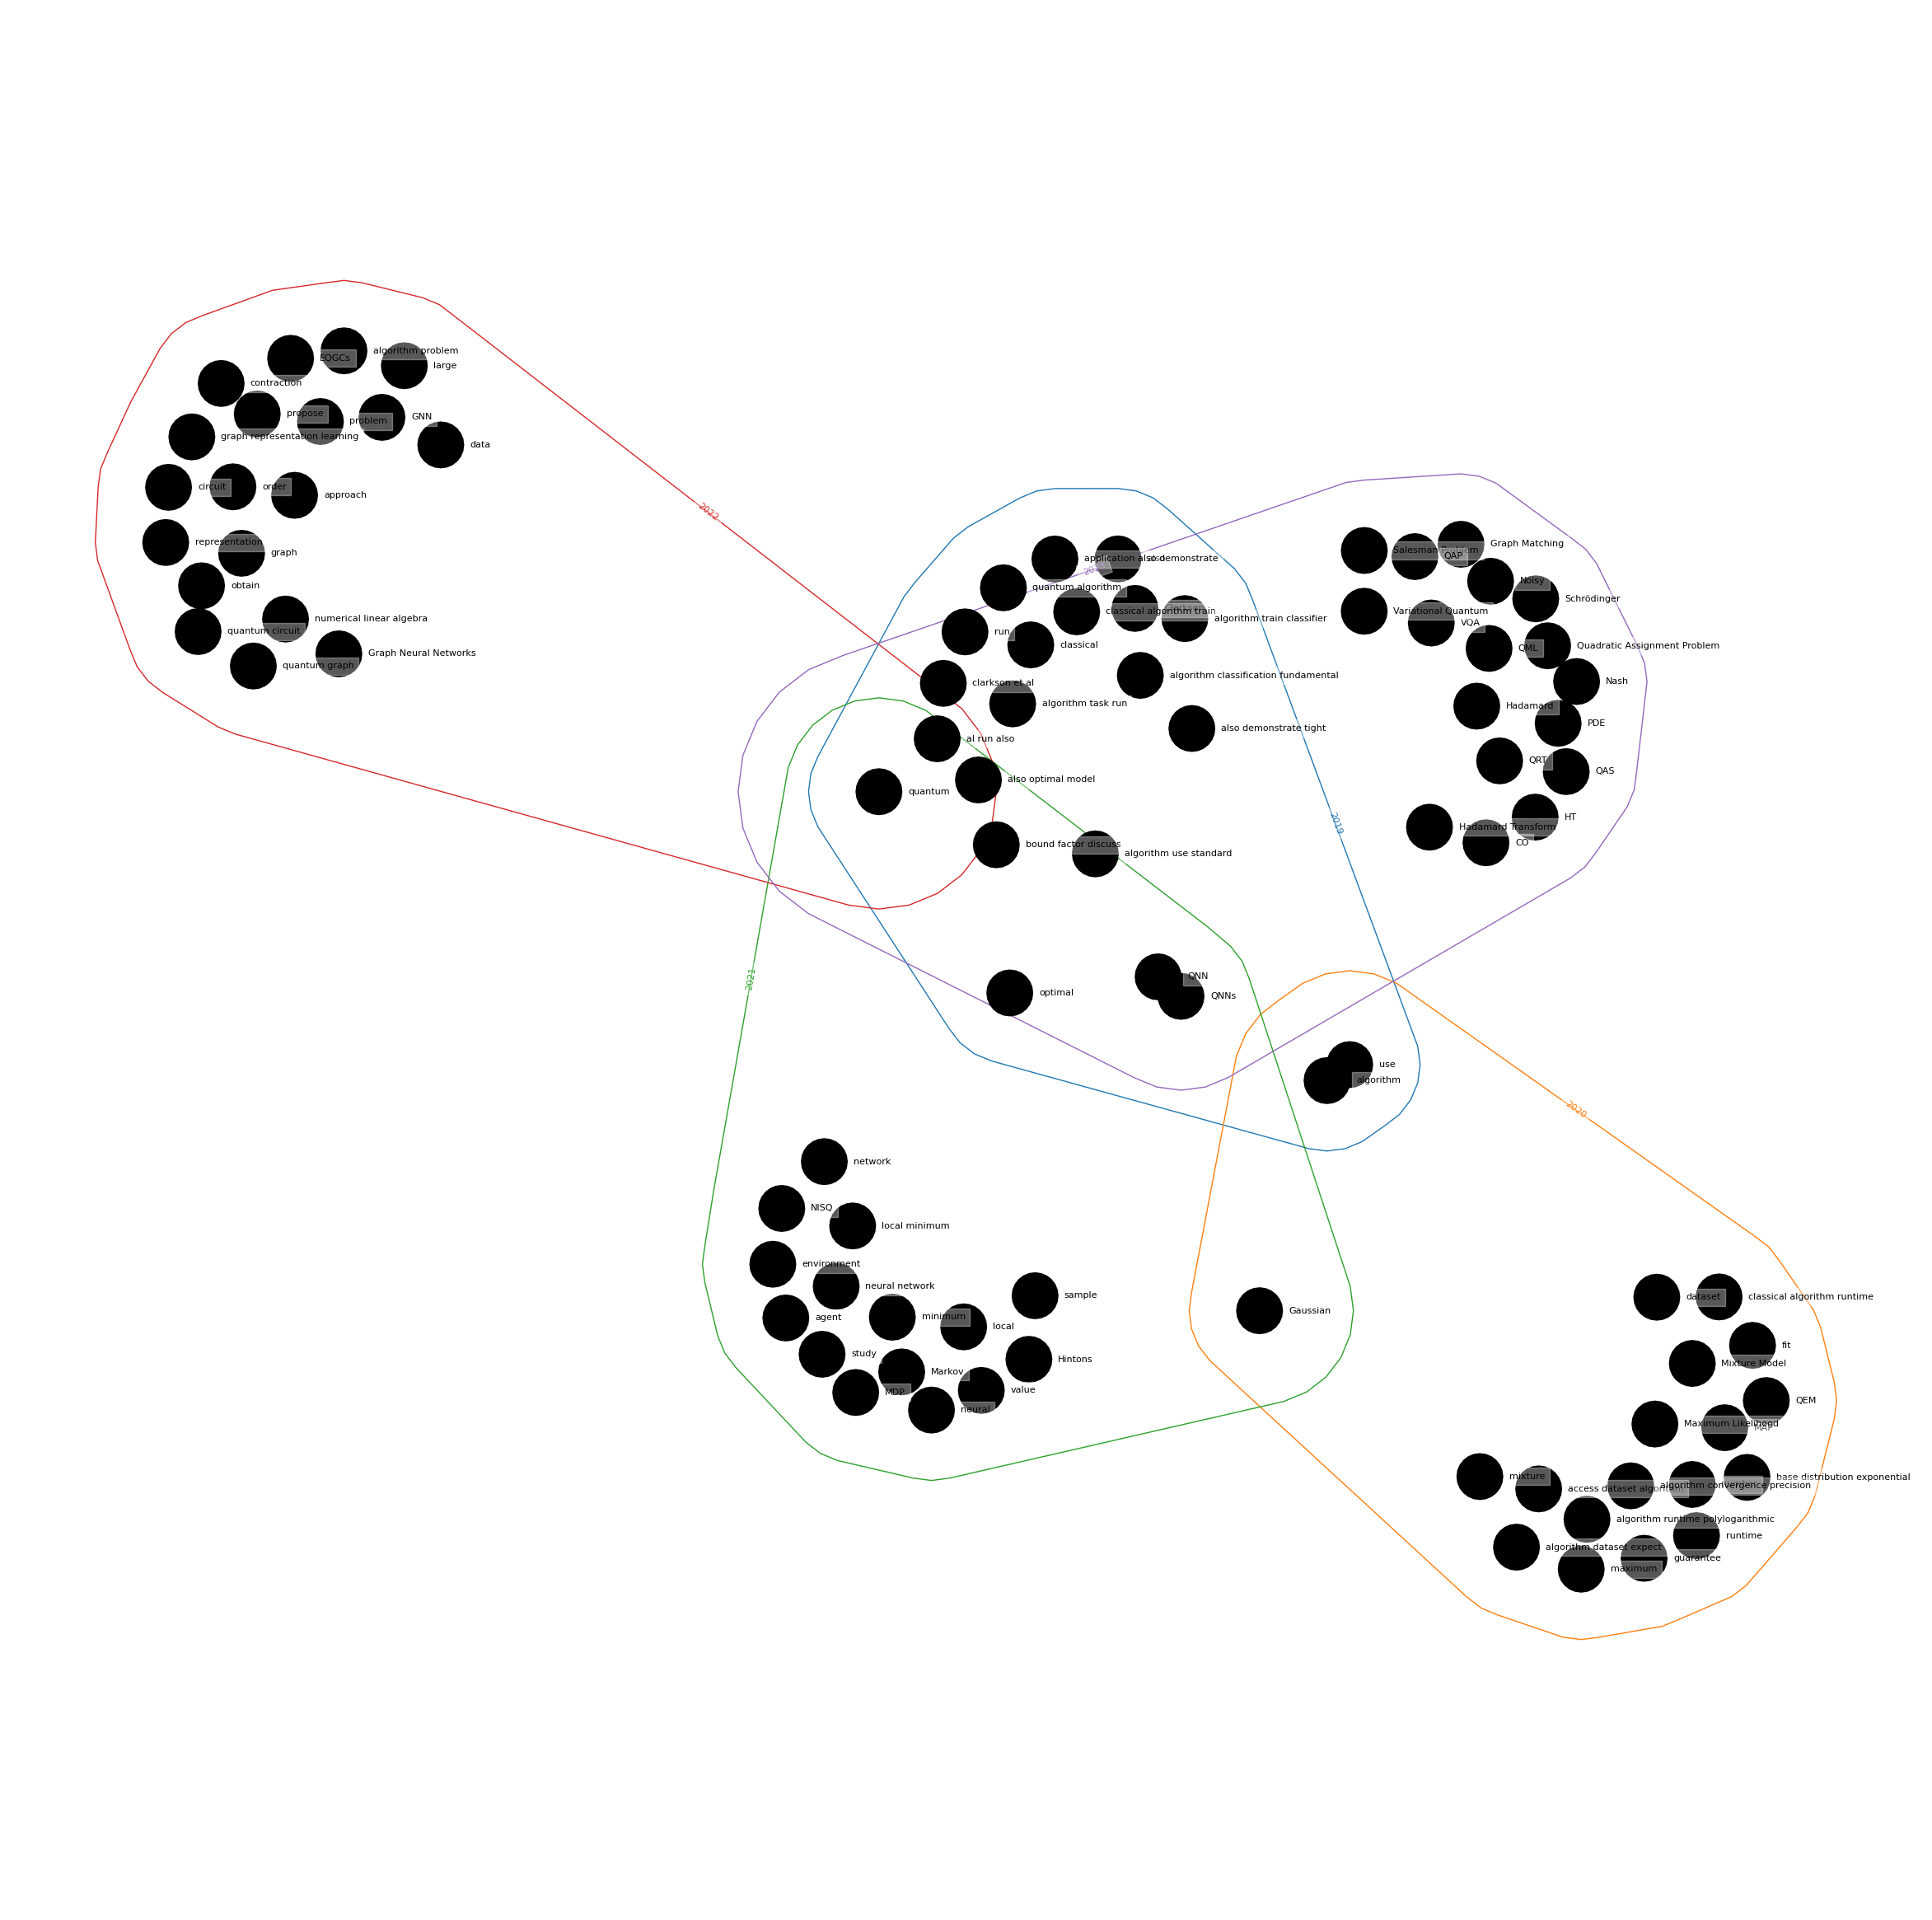

In [13]:
## Method 1
## Adjusting tf-idf scores, give more weights to named-entities and longer phrases

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
from nltk.stem import WordNetLemmatizer
import hypernetx as hnx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Preprocessing text: tokenizing, lemmatizing, removing stopwords, and extracting named entities
def preprocess_and_extract(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Named Entity Recognition with modification
    named_entities = []
    tree = ne_chunk(pos_tags, binary=False)
    previous_word = ""
    for subtree in tree:
        if isinstance(subtree, Tree):  # If the chunk is a named entity
            entity = " ".join([token for token, pos in subtree.leaves()])
            # Skip if entity is capitalized just because it's at the beginning of a sentence
            if entity != entity.upper() and (previous_word.endswith('.') or previous_word == ""):
                continue
            named_entities.append(entity)
        previous_word = subtree[0] if isinstance(subtree, tuple) else ' '.join([token for token, pos in subtree.leaves()])

    # Lemmatization and Stopword Removal
    lemmas = []
    for word, tag in pos_tags:
        if word.lower() not in stop_words:
            wntag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, pos=wntag) if wntag else word
            lemmas.append(lemma)

    # Filter out non-alphabetic tokens and convert to lowercase
    filtered_tokens = [lemma.lower() for lemma in lemmas if lemma.isalpha()]

    return filtered_tokens, named_entities

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


# Function to calculate TF-IDF and extract named entities with special weighting
def extract_keywords_with_tfidf(dataset, num_keywords=25, named_entity_length_factor=8, phrase_length_factor=0.1):
    preprocessed_texts = []
    all_named_entities = defaultdict(list)
    valid_years = []  # To keep track of years with non-empty data

    # Preprocess the text and extract named entities
    for year, text in dataset.items():
        if not text.strip():  # Skip empty text for a year
            continue
        valid_years.append(year)  # Add year to the list of valid years
        tokens, named_entities = preprocess_and_extract(text)
        preprocessed_texts.append(' '.join(tokens))
        all_named_entities[year].extend(named_entities)

    # Calculate TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Consider uni-, bi-, and tri-grams
    tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Map TF-IDF scores to corresponding years and words/phrases
    tfidf_scores = {
        year: dict(zip(feature_names, tfidf_matrix[valid_years.index(year)].toarray().flatten()))
        for year in valid_years
    }

    # Adjust weights for named entities
    for year, entities in all_named_entities.items():
        for entity in entities:
            entity_key = entity.lower()
            if entity_key in tfidf_scores.get(year, {}):
                original_score = tfidf_scores[year][entity_key]
                adjusted_score = original_score * named_entity_length_factor * len(entity.split())
                tfidf_scores[year][entity] = adjusted_score
                del tfidf_scores[year][entity_key]

    # Adjust weights for phrases (n-grams)
    for year, scores in tfidf_scores.items():
        for phrase in list(scores.keys()):
            if len(phrase.split()) > 1:  # It's a phrase
                scores[phrase] *= (1 + phrase_length_factor * (len(phrase.split()) - 1))

    # Extract top keywords based on the combined scores
    top_keywords_by_year = {
        year: sorted(tfidf_scores[year].items(), key=lambda item: item[1], reverse=True)[:num_keywords]
        for year in valid_years
    }

    return top_keywords_by_year


def create_hypergraph(cvpr_data, top_keywords, top_n=20):
    # Create hyperedges from top keywords, ignoring years with empty keyword sets
    hyperedges = {}
    for year, keywords in top_keywords.items():
        if keywords:  # Only include years with non-empty keyword lists
            hyperedges[year] = set([keyword for keyword, score in keywords][:top_n])

    if not hyperedges:  # Check if all years are empty
        print("No keywords available for any year to create a hypergraph.")
        return
        
    # Create hypergraph
    H = hnx.Hypergraph(hyperedges)

    # Set font sizes
    plt.rcParams['font.size'] = 8
    plt.rcParams['axes.labelsize'] = 28
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    # Plot hypergraph
    plt.figure(figsize=(30, 30))
    hnx.draw(H, with_edge_labels=True, layout_kwargs={'seed': 42})
    plt.show()

    return hyperedges

# Example usage with dummy data
data = {
    '2019': ''.join(icml_2019.loc[b4['point_indices_within_circle'][49]]['abstract']),
    '2020': ''.join(icml_2020.loc[b3['point_indices_within_circle'][49]]['abstract']),
    '2021': ''.join(icml_2021.loc[b2['point_indices_within_circle'][49]]['abstract']),
    '2022': ''.join(icml_2022.loc[b1['point_indices_within_circle'][49]]['abstract']),
    '2023': ''.join(icml_2023.loc[cluster_2023_icml['point_indices_within_cluster'][49]]['abstract'])
}

top_keywords = extract_keywords_with_tfidf(data, num_keywords=25, named_entity_length_factor=8, phrase_length_factor=0.01)
for year, keywords in top_keywords.items():
    print(f"Year: {year}")
    for keyword, score in keywords:
        print(f"{keyword}: {score}")
    print()

hyperedges = create_hypergraph(data, top_keywords)

Year: 2019
Clarkson: 0.23707500935145764
algorithm: 0.15062334961796298
classical: 0.11296751221347223
quantum: 0.11296751221347223
also: 0.1058479311772121
optimal: 0.1058479311772121
run: 0.1058479311772121
quantum algorithm: 0.0899330427709642
use: 0.08904261660491505
al run also: 0.0806055031794956
algorithm classification fundamental: 0.0806055031794956
algorithm task run: 0.0806055031794956
algorithm train classifier: 0.0806055031794956
algorithm use standard: 0.0806055031794956
also demonstrate tight: 0.0806055031794956
also optimal model: 0.0806055031794956
application also demonstrate: 0.0806055031794956
bound factor discuss: 0.0806055031794956
clarkson et al: 0.0806055031794956
classical algorithm train: 0.0806055031794956
classical input generate: 0.0806055031794956
classical output suggest: 0.0806055031794956
classification fundamental problem: 0.0806055031794956
classifier constant margin: 0.0806055031794956
constant margin clarkson: 0.0806055031794956

Year: 2020
Mixture 

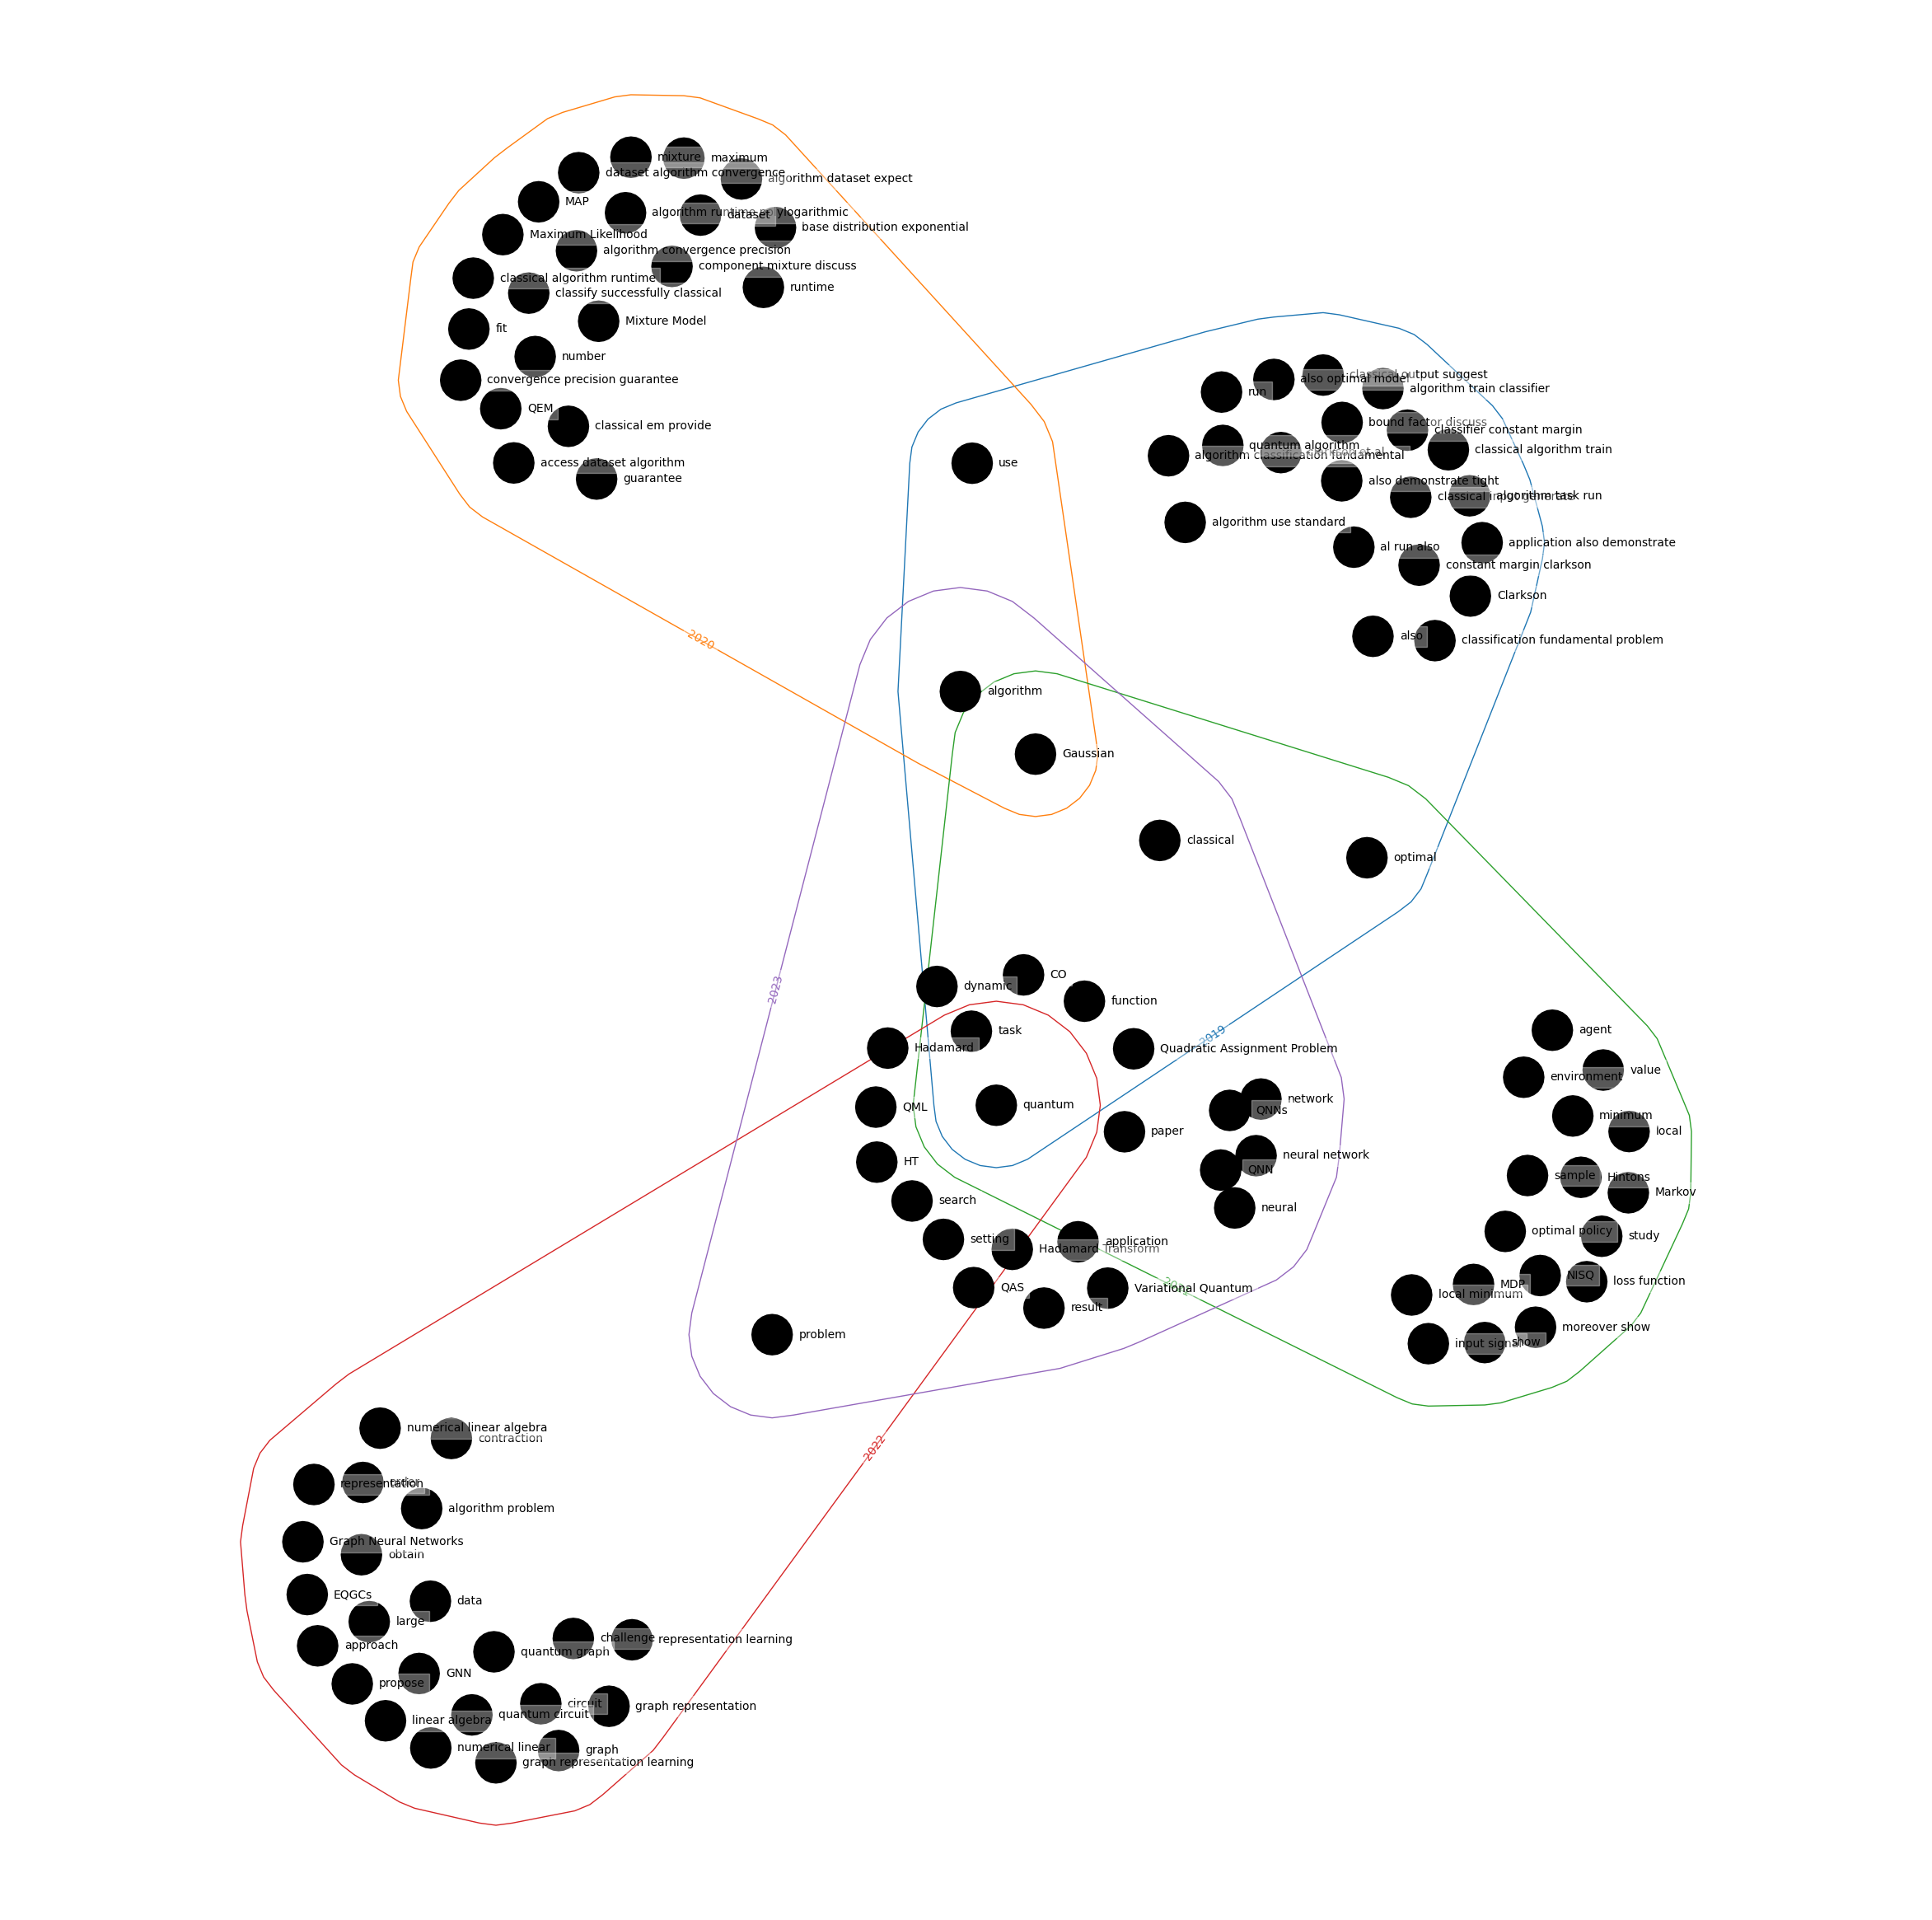

In [14]:
## Method 2
## Set a proportion of named-entities

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
from nltk.stem import WordNetLemmatizer
import hypernetx as hnx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Preprocessing text: tokenizing, lemmatizing, removing stopwords, and extracting named entities
def preprocess_and_extract(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Named Entity Recognition with modification
    named_entities = []
    tree = ne_chunk(pos_tags, binary=False)
    previous_word = ""
    for subtree in tree:
        if isinstance(subtree, Tree):  # If the chunk is a named entity
            entity = " ".join([token for token, pos in subtree.leaves()])
            # Skip if entity is capitalized just because it's at the beginning of a sentence
            if entity != entity.upper() and (previous_word.endswith('.') or previous_word == ""):
                continue
            named_entities.append(entity)
        previous_word = subtree[0] if isinstance(subtree, tuple) else ' '.join([token for token, pos in subtree.leaves()])

    # Lemmatization and Stopword Removal
    lemmas = []
    for word, tag in pos_tags:
        if word.lower() not in stop_words:
            wntag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, pos=wntag) if wntag else word
            lemmas.append(lemma)

    # Filter out non-alphabetic tokens and convert to lowercase
    filtered_tokens = [lemma.lower() for lemma in lemmas if lemma.isalpha()]

    return filtered_tokens, named_entities

# Function to calculate TF-IDF and extract named entities with special weighting

def extract_keywords_with_tfidf(dataset, num_keywords=20, named_entity_proportion=0.5, named_entity_length_factor=1.5, phrase_length_factor=0.1):
    preprocessed_texts = []
    all_named_entities = defaultdict(list)
    valid_years = []  # To keep track of years with non-empty data

    # Preprocess the text and extract named entities
    for year, text in dataset.items():
        if not text.strip():  # Skip empty text for a year
            continue
        valid_years.append(year)  # Add year to the list of valid years
        tokens, named_entities = preprocess_and_extract(text)
        preprocessed_texts.append(' '.join(tokens))
        all_named_entities[year].extend(named_entities)

    # Calculate TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Consider uni-, bi-, and tri-grams
    tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Map TF-IDF scores to corresponding years and words/phrases
    tfidf_scores = {
        year: dict(zip(feature_names, tfidf_matrix[valid_years.index(year)].toarray().flatten()))
        for year in valid_years
    }

    # Process named entities and adjust their weights
    ne_scores = defaultdict(Counter)
    for year, entities in all_named_entities.items():
        for entity in entities:
            entity_key = entity.lower()
            if entity_key in tfidf_scores.get(year, {}):
                original_score = tfidf_scores[year][entity_key]
                adjusted_score = original_score * named_entity_length_factor * len(entity.split())
                ne_scores[year][entity] = adjusted_score
                del tfidf_scores[year][entity_key]

    # Adjust weights for phrases (n-grams)
    for year, scores in tfidf_scores.items():
        for phrase in list(scores.keys()):
            if len(phrase.split()) > 1:  # It's a phrase
                scores[phrase] *= (1 + phrase_length_factor * (len(phrase.split()) - 1))

    # Extract top keywords by combining named entities and TF-IDF scores
    top_keywords_by_year = {}
    for year in valid_years:
        num_ne_keywords = int(num_keywords * named_entity_proportion)
        top_named_entities = sorted(ne_scores[year].items(), key=lambda item: item[1], reverse=True)[:num_ne_keywords]
        remaining_keywords = num_keywords - len(top_named_entities)
        top_tfidf_keywords = sorted(tfidf_scores[year].items(), key=lambda item: item[1], reverse=True)[:remaining_keywords]
        top_keywords_by_year[year] = top_named_entities + top_tfidf_keywords

    return top_keywords_by_year


# Helper functions (get_wordnet_pos etc.) and example usage remain the same as in your original code
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None



def create_hypergraph(cvpr_data, top_keywords):
    # Create hyperedges from top keywords
    hyperedges = {}
    for year, keywords in top_keywords.items():
        hyperedges[year] = set([keyword for keyword, score in keywords])

    # Create hypergraph
    H = hnx.Hypergraph(hyperedges)

    # Set font sizes
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelsize'] = 28
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5


    # Plot hypergraph
    plt.figure(figsize=(30, 30))
    hnx.draw(H, with_edge_labels=True)#, layout_kwargs={'seed': 42})

    
    plt.show()

   
    return hyperedges

# Example usage with dummy data
data = {
    '2019': ''.join(icml_2019.loc[b4['point_indices_within_circle'][49]]['abstract']),
    '2020': ''.join(icml_2020.loc[b3['point_indices_within_circle'][49]]['abstract']),
    '2021': ''.join(icml_2021.loc[b2['point_indices_within_circle'][49]]['abstract']),
    '2022': ''.join(icml_2022.loc[b1['point_indices_within_circle'][49]]['abstract']),
    '2023': ''.join(icml_2023.loc[cluster_2023_icml['point_indices_within_cluster'][49]]['abstract'])
}

top_keywords = extract_keywords_with_tfidf(data, num_keywords=25,named_entity_proportion=0.4, named_entity_length_factor=3, phrase_length_factor=0.01)
for year, keywords in top_keywords.items():
    print(f"Year: {year}")
    for keyword, score in keywords:
        print(f"{keyword}: {score}")
    print()

hyperedges = create_hypergraph(data, top_keywords)

Year: 2019
Clarkson: 0.2492384785170529
classical: 0.11876347044323884
quantum: 0.11876347044323884
also: 0.11127860921720498
optimal: 0.11127860921720498
run: 0.11127860921720498
use: 0.09361107417646865
al run also: 0.084741082695798
also demonstrate tight: 0.084741082695798
also optimal model: 0.084741082695798
application also demonstrate: 0.084741082695798
bound factor discuss: 0.084741082695798
clarkson et al: 0.084741082695798
classical input generate: 0.084741082695798
classical output suggest: 0.084741082695798
classical train classifier: 0.084741082695798
classification fundamental problem: 0.084741082695798
classifier constant margin: 0.084741082695798
constant margin clarkson: 0.084741082695798
demonstrate tight low: 0.084741082695798
design sublinear quantum: 0.084741082695798
discuss possibility implementation: 0.084741082695798
et al run: 0.084741082695798
factor discuss possibility: 0.084741082695798
fundamental problem machine: 0.084741082695798

Year: 2020
Mixture Mod

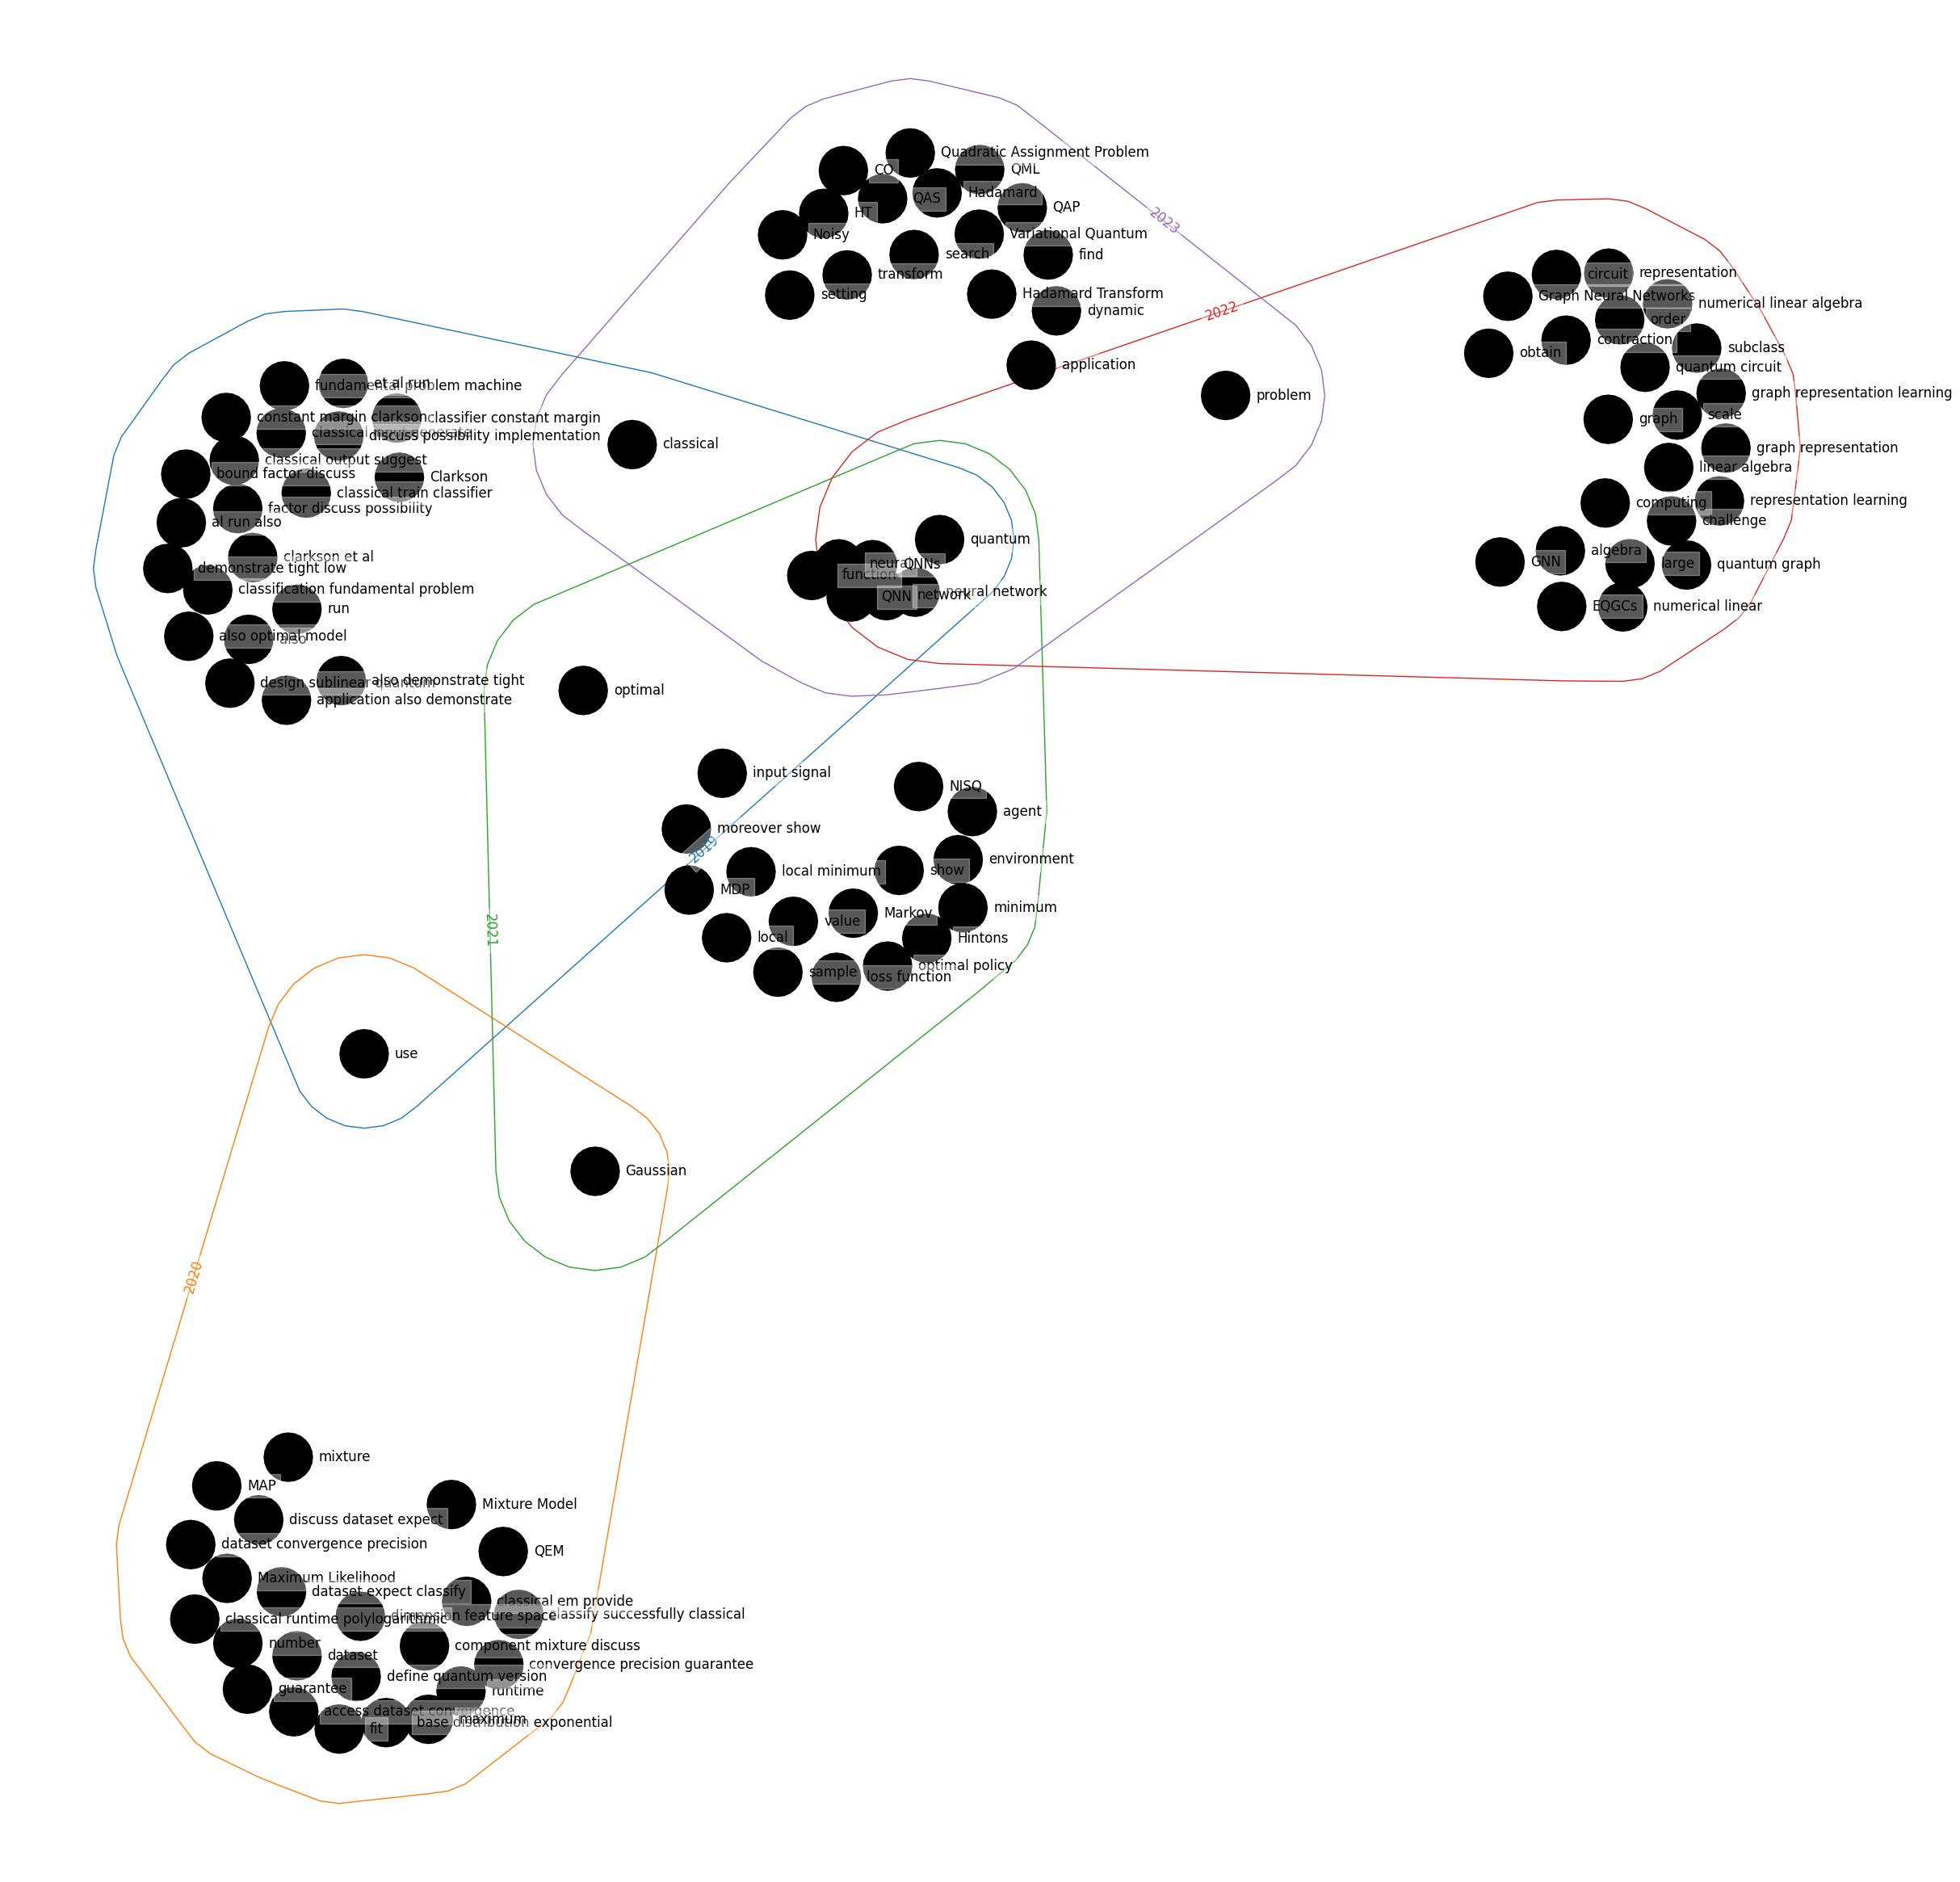

In [15]:
## Method 2 (Mofidied, add some words to exclude from keywords)
## Set a proportion of named-entities

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd
from nltk.stem import WordNetLemmatizer
import hypernetx as hnx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize


# List of words to exclude from keyword extraction
exclusion_list = ['propose', 'method', 'task', 'approach', 'algorithm', 'system', 'technique', 'framework', 'performance', 'result', 'analysis', 'study', 'research', 'data', 'work', 'paper', 'findings', 'discussion', 'conclusion']


# Preprocessing text: tokenizing, lemmatizing, removing stopwords, and extracting named entities
def preprocess_and_extract(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Named Entity Recognition with modification
    named_entities = []
    tree = ne_chunk(pos_tags, binary=False)
    previous_word = ""
    for subtree in tree:
        if isinstance(subtree, Tree):  # If the chunk is a named entity
            entity = " ".join([token for token, pos in subtree.leaves()])
            # Skip if entity is capitalized just because it's at the beginning of a sentence
            if entity != entity.upper() and (previous_word.endswith('.') or previous_word == ""):
                continue
            named_entities.append(entity)
        previous_word = subtree[0] if isinstance(subtree, tuple) else ' '.join([token for token, pos in subtree.leaves()])

    # Lemmatization and Stopword Removal
    lemmas = []
    for word, tag in pos_tags:
        if word.lower() not in stop_words:
            wntag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, pos=wntag) if wntag else word
            lemmas.append(lemma)

    # Filter out non-alphabetic tokens and convert to lowercase
    filtered_tokens = [lemma.lower() for lemma in lemmas if lemma.isalpha()]

    return filtered_tokens, named_entities

# Function to calculate TF-IDF and extract named entities with special weighting

def extract_keywords_with_tfidf(dataset, num_keywords=25, named_entity_proportion=0.5, named_entity_length_factor=1.5, phrase_length_factor=0.1):
    preprocessed_texts = []
    all_named_entities = defaultdict(list)
    valid_years = []

    # Preprocess the text and extract named entities
    for year, text in dataset.items():
        if text.strip():  # Check if text is not empty
            tokens, named_entities = preprocess_and_extract(text)
            preprocessed_texts.append(' '.join(tokens))
            all_named_entities[year].extend(named_entities)
            valid_years.append(year)

    # Calculate TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words=exclusion_list)
    tfidf_matrix = vectorizer.fit_transform(preprocessed_texts)
    feature_names = vectorizer.get_feature_names_out()

    # Map TF-IDF scores to corresponding years and words/phrases
    tfidf_scores = {}
    for idx, year in enumerate(valid_years):
        tfidf_scores[year] = dict(zip(feature_names, tfidf_matrix[idx].toarray().flatten()))

    # Process named entities and adjust their weights
    ne_scores = defaultdict(Counter)
    for year, entities in all_named_entities.items():
        for entity in entities:
            entity_key = entity.lower()
            if entity_key in tfidf_scores[year]:
                original_score = tfidf_scores[year][entity_key]
                adjusted_score = original_score * named_entity_length_factor * len(entity.split())
                ne_scores[year][entity] = adjusted_score
                del tfidf_scores[year][entity_key]

    # Adjust weights for phrases (n-grams)
    for year, scores in tfidf_scores.items():
        for phrase in list(scores.keys()):
            if len(phrase.split()) > 1:  # It's a phrase
                scores[phrase] *= (1 + phrase_length_factor * (len(phrase.split()) - 1))

    # Extract top keywords by combining named entities and TF-IDF scores
    top_keywords_by_year = {}
    for year in valid_years:
        num_ne_keywords = int(num_keywords * named_entity_proportion)
        top_named_entities = sorted(ne_scores[year].items(), key=lambda item: item[1], reverse=True)[:num_ne_keywords]
        remaining_keywords = num_keywords - len(top_named_entities)
        top_tfidf_keywords = sorted(tfidf_scores[year].items(), key=lambda item: item[1], reverse=True)[:remaining_keywords]
        top_keywords_by_year[year] = top_named_entities + top_tfidf_keywords
    
    return top_keywords_by_year



# Helper functions (get_wordnet_pos etc.) and example usage remain the same as in your original code
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None



def create_hypergraph(cvpr_data, top_keywords):
    # Create hyperedges from top keywords
    hyperedges = {}
    for year, keywords in top_keywords.items():
        if year in cvpr_data and cvpr_data[year].strip():  # Check if the year has data
            hyperedges[year] = set([keyword for keyword, score in keywords])

    # Create hypergraph
    H = hnx.Hypergraph(hyperedges)

    # Set font sizes
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 28
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10


    # Plot hypergraph
    plt.figure(figsize=(30, 30))
    hnx.draw(H, with_edge_labels=True)#, layout_kwargs={'seed': 42})

    
    plt.show()

   
    return hyperedges

# Example usage with dummy data
data = {
    '2019': ''.join(icml_2019.loc[b4['point_indices_within_circle'][49]]['abstract']),
    '2020': ''.join(icml_2020.loc[b3['point_indices_within_circle'][49]]['abstract']),
    '2021': ''.join(icml_2021.loc[b2['point_indices_within_circle'][49]]['abstract']),
    '2022': ''.join(icml_2022.loc[b1['point_indices_within_circle'][49]]['abstract']),
    '2023': ''.join(icml_2023.loc[cluster_2023_icml['point_indices_within_cluster'][49]]['abstract'])
}

top_keywords = extract_keywords_with_tfidf(data, num_keywords=25, named_entity_proportion=0.5, named_entity_length_factor=3, phrase_length_factor=0.01)
for year, keywords in top_keywords.items():
    print(f"Year: {year}")
    for keyword, score in keywords:
        print(f"{keyword}: {score}")
    print()

hyperedges = create_hypergraph(data, top_keywords)